In [10]:
from collections.abc import Iterable
import os

from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import pywt
import scipy.io as sio
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile
import tifffile

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [2]:
import os
import PyQt6.QtCore
os.environ["QT_API"] = "pyqt6"


## Test NWB files

In [48]:
filepath = '/Users/danielysprague/foco_lab/data/NWB_NP_Flavell/2023-01-16-01.nwb'
#filepath = '/Users/danielysprague/foco_lab/data/NWB_foco/2021-12-03-w00-NP1.nwb'

with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
    read_nwb = io.read()
    identifier = read_nwb.identifier
    seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
    labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
    #labels_index = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels_index'][:]
    channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
    scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

read_nwb




root pynwb.file.NWBFile at 0x12408697296
Fields:
  acquisition: {
    NeuroPALImageRaw <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolume'>
  }
  devices: {
    NIR Config <class 'pynwb.device.Device'>,
    Spinning Disk Confocal <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2023, 12, 13, 12, 32, 37, 690149, tzinfo=tzoffset(None, -28800))]
  identifier: 2023-01-16-01
  imaging_planes: {
    NeuroPALImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>
  }
  institution: MIT
  lab: Flavell Laboratory
  processing: {
    Behavior <class 'pynwb.base.ProcessingModule'>,
    NeuroPAL <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['https://doi.org/10.1016/j.cell.2023.07.035']
  session_description: Ventral cord at the bottom when head faces left; one row of mature eggs
Heat stim t~801
Occasional pumping pre-stim, no pumping post-stim
Large stage jitter t~900 and t~1200
Quite a bit of reversals pre-stim already, but more & longer reversals post-stim
07 is a backup of 02, gliding +, head posture stationary

  session_start_time: 2023-01-16 00:00:00-08:00
  subject: subject abc.CElegansSubject at 0x12412619536
Fields:
  age__reference: birth
  cultivation_temp: 22.0
  date_of_birth: 2023-01-16 00:00:00-08:00
  description: Ventral cord at the bottom when head faces left; one row of mature eggs
Heat stim t~801
Occasional pumping pre-stim, no pumping post-stim
Large stage jitter t~900 and t~1200
Quite a bit of reversals pre-stim already, but more & longer reversals post-stim
07 is a backup of 02, gliding +, head posture stationary

  growth_stage: young adult
  growth_stage_time: nan
  sex: hermaphrodite
  species: C. Elegans
  strain: SWF702
  subject_id: 2023-01-16 00:00:00-SWF702

  timestamps_reference_time: 2023-01-16 00:00:00-08:00

## Figure 1: Visualizations of NWB file contents

This will probably be an illustrator created visual which shows all of the different objects that go into the NWB file and how they interplay with each other. Similar to how it is shown in the NWB tutorails

## Atlas and data visualizations

In [63]:
NWB_atlas_kimura = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_11_14_1_full.pkl')

In [106]:
NWB_atlas_full = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_13_2_full.pkl')

In [56]:
NP_atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/NP_original.pkl') #Atlas trained on just original 10 NeuroPAL datasets

In [66]:
%matplotlib qt
'''
Plot unrolled, color plots, and XY/XZ projections of atlas
'''

plot_visualizations_atlas(NWB_atlas_full)
plot_visualizations_atlas(NWB_atlas_kimura)
plot_visualizations_atlas(NP_atlas)

In [107]:
%matplotlib qt
'''
Plot unrolled, color plots, and XY/XZ projections of individual dataset
'''

df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/aligned_full/20230928-16-0-0.csv')
#df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/aligned_full/2022-06-14-01.csv')
df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

plot_visualizations_data(df_data, NWB_atlas_full, vRecenter = [60,10,-10])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [19]:
%matplotlib qt

'''
Plot dataset point cloud super-imposed onto atlas with both XY and XZ projections
'''

df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/aligned_NP/38_YAaLR.csv')
df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

plot_atlas2d_super(df_data, NP_atlas)


In [38]:
%matplotlib qt

traces = np.transpose(fluor)

labels = ["".join(label) for label in labels]

def plot_traces(traces, rate, labels, selected):

    seconds = traces.shape[1]//rate

    fig, axs = plt.subplots(len(selected),1, figsize=(5,6))

    for i, neuron in enumerate(selected):
        index = np.argwhere(np.asarray(labels)==neuron)
        trace = traces[np.squeeze(index),:]

        axs[i].plot(np.linspace(0,seconds,traces.shape[1]), trace)
        axs[i].set_xlabel('seconds')
        axs[i].set_ylabel('DFoF')
        axs[i].set_xlim(0,seconds)
        axs[i].set_title(neuron)

    plt.tight_layout()
    plt.show()

plot_traces(traces, rate, labels, ['AVAR', 'SMDVR', 'AWCR','RID', 'ASHR'])

2023-12-04 15:14:33.047 python[55407:54048270] +[CATransaction synchronize] called within transaction


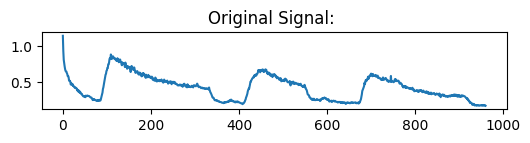

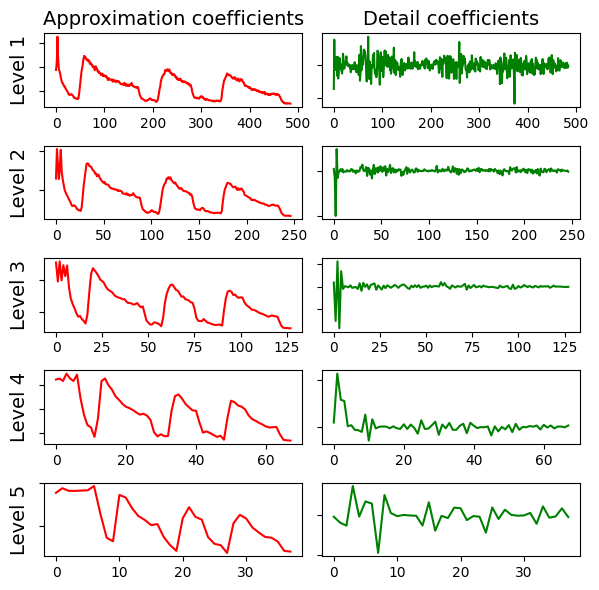

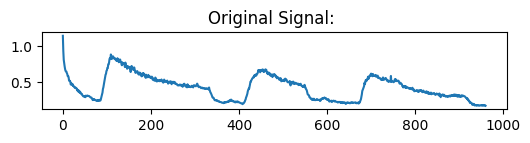

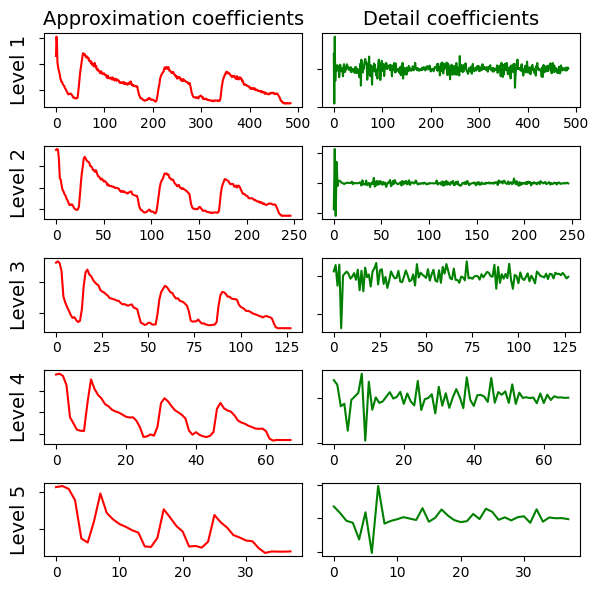

In [130]:
def plot_wavelet_decomp(signal, waveletname, level):
    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Signal: ")
    ax.plot(signal)
    plt.show()
        
    data = signal

    detail_coefs = []
    
    fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
    for ii in range(level):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        detail_coefs.append(coeff_d)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')
        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        axarr[ii, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    return detail_coefs

coefs_db5 = plot_wavelet_decomp(trace, 'db5', 5)
coefs_sym5 = plot_wavelet_decomp(trace, 'sym5', 5)

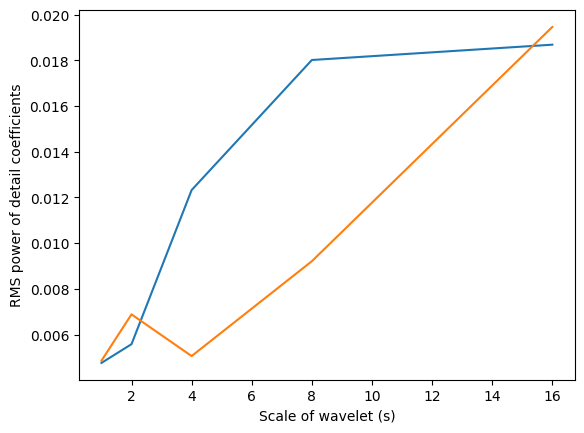

In [36]:
db5_power = []
sym5_power = []

for i in range(len(coefs_db5)):
    db5_power.append(np.sqrt(np.mean(coefs_db5[i]**2)))
    sym5_power.append(np.sqrt(np.mean(coefs_sym5[i]**2)))

plt.plot(2**np.linspace(0,4,5),db5_power)
plt.plot(2**np.linspace(0,4,5),sym5_power)
plt.xlabel('Scale of wavelet (s)')
plt.ylabel('RMS power of detail coefficients')

plt.show()



In [4]:
filepath = '/Users/danielysprague/foco_lab/data/kimura_full/sub-230928-02_ses-20230928T111400_ophys.nwb'

with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
    read_nwb = io.read()
    seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
    labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
    channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
    scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

    fluor = read_nwb.processing['CalciumActivity']['SignalRawFluor']['SignalCalciumImResponseSeries'].data[:]
    calc_labels = read_nwb.processing['CalciumActivity']['NeuronIDs'].labels[:]

print(labels)
print(calc_labels)

read_nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
[array(['A', 'M', 'S', 'O', 'L'], dtype=object), array(['I', '1', 'R'], dtype=object), array(['I', '1', 'L'], dtype=object), array(['A', 'M', 'S', 'O', 'R'], dtype=object), array(['M', 'C', 'L'], dtype=object), array(['M', 'C', 'R'], dtype=object), array(['I', '2', 'R'], dtype=object), array(['I', '2', 'L'], dtype=object), array(['M', 'I'], dtype=object), array(['N', 'S', 'M', 'R'], dtype=object), array(['N', 'S', 'M', 'L'], dtype=object), array(['I', '3'], dtype=object), array(['I', 'L', '2', 'V', 'R'], dtype=object), array(['M', '3', 'R'], dtype=object), array(['I', 'L', '1', 'V', 'R'], dtype=object), array(['M', '4'], dtype=object), array(['M', '3', 'L'], dtype=object), array(['I', 'L', '1', 'V', 'L'], dtype=object), array(['R', 'I', 'P', 'R'], dtype=object), array(['I', 'L', '2', 'D', 'R'], dtype=object), array(['I', 'L', '2', 'D', 'L'], dtype=object), array(['U', 'R', 'A',

root pynwb.file.NWBFile at 0x6300819408
Fields:
  acquisition: {
    CalciumImageSeries <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolumeSeries'>,
    NeuroPALImageRaw <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolume'>
  }
  devices: {
    Spinning disk confocal <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2023, 10, 9, 9, 26, 26, 191887, tzinfo=tzoffset(None, 32400))]
  identifier: 20230928-11-14-0
  imaging_planes: {
    CalciumImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>,
    NeuroPALImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>
  }
  institution: Nagoya City University
  lab: Kimura lab
  processing: {
    CalciumActivity <class 'pynwb.base.ProcessingModule'>,
    NeuroPAL <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['unpublished']
  session_description: NeuroPAL+ Calcium Imaging without Stimulation
  session_start_time: 2023-09-28 11:14:00+09:00
  subject: subject abc.CElegansSubject at 0x6301524880
Fields:
  age__reference: birth
  cultivation_temp: 20.0
  date_of_birth: 2023-09-25 00:00:00+09:00
  description: none
  growth_stage: YA
  sex: O
  species: http://purl.obolibrary.org/obo/NCBITaxon_6239
  strain: KDK92
  subject_id: 230928_02

  timestamps_reference_time: 2023-09-28 11:14:00+09:00

In [31]:
labels = sio.loadmat('/Users/danielysprague/foco_lab/data/Yemini_21/OH16230/Heads/20190924_01/')['gclabels']
gclabels = np.asarray([label.replace(" ","") for label in labels])
print(gclabels.shape)

(181,)


In [17]:
import nrrd

file, header = nrrd.read('/Users/danielysprague/foco_lab/data/Flavell_example/prj_neuropal/2022-06-14-01/NeuroPAL.nrrd', index_order='C')

print(header.keys())

odict_keys(['type', 'dimension', 'space', 'sizes', 'space directions', 'kinds', 'endian', 'encoding', 'space origin'])


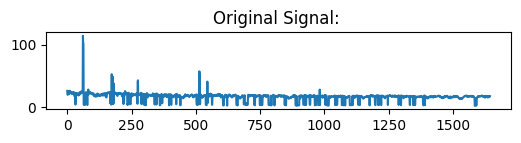

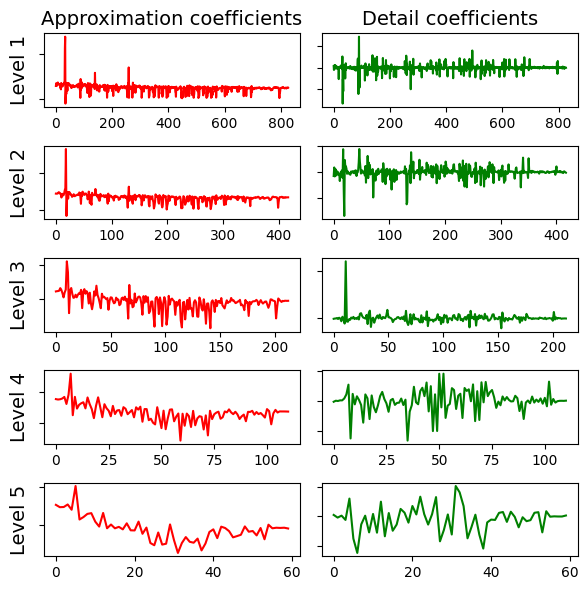

In [135]:
coefs_sym5 = plot_wavelet_decomp(fluor[:,0], 'sym5', 5)

In [39]:
%matplotlib qt

AVA_traces = []
SMDV_traces = []
AWC_traces = []
ASH_traces = []
RID_traces = []

for file in os.listdir('/Users/danielysprague/foco_lab/data/kimura_full'):
    if not file[-4:] == '.nwb':
        continue

    filepath = '/Users/danielysprague/foco_lab/data/kimura_full/' + file

    with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
        read_nwb = io.read()
        seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
        labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
        channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
        image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
        scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

        fluor = read_nwb.processing['CalciumActivity']['SignalRawFluor']['SignalCalciumImResponseSeries'].data[:]
        calc_labels = read_nwb.processing['CalciumActivity']['NeuronIDs'].labels[:]
        rate = read_nwb.acquisition['CalciumImageSeries'].rate

    index_AVA = np.argwhere((np.asarray(calc_labels)=='AVAR') | (np.asarray(calc_labels)=='AVAL'))
    index_SMDV = np.argwhere((np.asarray(calc_labels)=='SMDVR') | (np.asarray(calc_labels)=='SMDVL'))
    index_AWC = np.argwhere((np.asarray(calc_labels)=='AWCR') | (np.asarray(calc_labels)=='AWCL'))
    index_ASH = np.argwhere((np.asarray(calc_labels)=='ASHR') | (np.asarray(calc_labels)=='ASHL'))
    index_RID = np.argwhere(np.asarray(calc_labels)=='RID')
    AVA_traces = AVA_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_AVA if index is not None]
    SMDV_traces = SMDV_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_SMDV if index is not None]
    AWC_traces = AWC_traces + [np.squeeze(fluor[:, index]/np.mean(fluor[:,index])) for index in index_AWC if index is not None]
    ASH_traces = ASH_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_ASH if index is not None]
    RID_traces = RID_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_RID if index is not None]

#for i, trace in enumerate(AVA_traces):
#    plt.plot(np.linspace(0,985,1645), trace[:1645], alpha=0.5)
#plt.show()

#for i, trace in enumerate(AVA_traces):
#    plt.plot(np.fft.fft(trace[:1645], axis=0), alpha=0.5)

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


In [29]:
%matplotlib qt

AVA_traces = []
SMDV_traces = []
AWC_traces = []
ASH_traces = []
RID_traces = []

for file in os.listdir('/Users/danielysprague/foco_lab/data/Yemini_NWB'):
    if not file[-4:] == '.nwb':
        continue

    filepath = '/Users/danielysprague/foco_lab/data/Yemini_NWB/' + file

    with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
        read_nwb = io.read()
        seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
        labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
        channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
        image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
        scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

        fluor = read_nwb.processing['CalciumActivity']['SignalRawFluor']['SignalCalciumImResponseSeries'].data[:]
        calc_labels = read_nwb.processing['CalciumActivity']['NeuronIDs'].labels[:]
        rate = read_nwb.acquisition['CalciumImageSeries'].rate

    index_AVA = np.argwhere((np.asarray(calc_labels)=='AVAR') | (np.asarray(calc_labels)=='AVAL'))
    index_SMDV = np.argwhere((np.asarray(calc_labels)=='SMDVR') | (np.asarray(calc_labels)=='SMDVL'))
    index_AWC = np.argwhere((np.asarray(calc_labels)=='AWCR') | (np.asarray(calc_labels)=='AWCL'))
    index_ASH = np.argwhere((np.asarray(calc_labels)=='ASHR') | (np.asarray(calc_labels)=='ASHL'))
    index_RID = np.argwhere(np.asarray(calc_labels)=='RID')
    AVA_traces = AVA_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_AVA if index is not None]
    SMDV_traces = SMDV_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_SMDV if index is not None]
    AWC_traces = AWC_traces + [np.squeeze(fluor[:, index]/np.mean(fluor[:,index])) for index in index_AWC if index is not None]
    ASH_traces = ASH_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_ASH if index is not None]
    RID_traces = RID_traces + [np.squeeze(fluor[:,index]/np.mean(fluor[:,index])) for index in index_RID if index is not None]

#for i, trace in enumerate(AVA_traces):
#    plt.plot(np.linspace(0,985,1645), trace[:1645], alpha=0.5)
#plt.show()

#for i, trace in enumerate(AVA_traces):
#    plt.plot(np.fft.fft(trace[:1645], axis=0), alpha=0.5)
#plt.show()

dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(

In [30]:
def plot_wavelet_decomp(signal, waveletname, level):
    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Signal: ")
    ax.plot(signal)
    plt.show()
        
    data = signal

    detail_coefs = []
    
    fig, axarr = plt.subplots(nrows=level, ncols=2, figsize=(6,6))
    for ii in range(level):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        detail_coefs.append(coeff_d)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')
        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        axarr[ii, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    return detail_coefs

In [31]:
def get_wavelet_decomp(signal, waveletname, level):

    detail_coefs = []
    approx_coefs = []
    detail_power = []
    
    data=signal

    for ii in range(level):
        (data, coeffs_d) = pywt.dwt(data, waveletname)
        approx_coefs.append(data)
        detail_coefs.append(coeffs_d)
        detail_power.append(np.sqrt(np.mean(coeffs_d**2)))

    return approx_coefs, detail_coefs, detail_power


In [32]:
plot_wavelet_decomp(fluor[:,5], 'sym5', 5)

[array([ 2.57721334e-03, -7.46632027e-03,  7.15988181e-03, -1.44117871e-03,
        -4.15233247e-03,  4.22730481e-03, -3.19780754e-03, -3.34463858e-03,
        -3.97094619e-03,  7.93016148e-03, -3.56094554e-03,  7.65296780e-03,
        -4.19986833e-03,  1.83350630e-03, -5.63526288e-03, -5.54245115e-04,
        -2.67031189e-03, -4.53686087e-05,  5.19410630e-03,  9.41601476e-03,
         2.40097736e-05,  7.74543812e-03, -2.14957628e-03,  7.65596760e-03,
         8.50739481e-05, -8.97536777e-03, -1.05236357e-02, -9.01459226e-03,
        -8.92842246e-03,  8.57491816e-05, -1.23102293e-03,  2.78228769e-03,
        -4.51993013e-03, -8.53542523e-04, -8.63898349e-03, -4.90374259e-03,
         4.02247367e-03,  9.59706985e-03, -2.71918891e-03, -1.14333932e-03,
        -1.33556515e-02, -2.61397676e-03, -1.03753125e-03, -1.41992181e-02,
        -5.90137224e-03,  5.72363690e-03, -2.70812392e-03,  1.55719348e-04,
         1.71149951e-03, -2.48467658e-03, -2.88287768e-03,  4.21485251e-05,
         2.7

In [16]:
plot_wavelet_decomp(np.squeeze(AVA_traces[5]), 'sym5', 5)

[array([-1.14340630e-01,  4.69769305e-04, -3.08991844e-02,  5.37896139e-02,
         2.48475356e-01,  3.52101628e-02, -3.60262168e-03,  3.62174487e-02,
         2.12867074e-02,  3.35257550e-02, -3.62450310e-02,  8.62249379e-02,
         1.14913020e-02,  1.43993546e-02,  1.66819856e-01, -1.28605146e-01,
        -7.42428889e-02, -5.25510167e-02, -8.49220096e-02, -9.41997481e-03,
         5.45473280e-02, -1.61692641e-02,  2.25601324e-03,  3.43347493e-02,
        -1.26406643e-03, -7.39911786e-02, -5.12243025e-02,  2.62582105e-02,
         1.87292744e-02,  1.49180128e-02, -8.51111521e-03,  8.13339826e-02,
        -2.90818789e-02, -2.34300143e-01,  1.39779763e-03, -9.39844945e-02,
         1.49910095e-02,  4.44794437e-02, -7.54255302e-02,  7.30518660e-02,
        -6.65907373e-02,  2.61073250e-02, -2.26140089e-02,  4.65088681e-03,
         3.47457560e-02, -1.64708726e-01, -1.19315870e-03,  6.01166539e-02,
         1.18953087e-02, -1.62653646e-01, -1.72825671e-01,  3.91069098e-02,
        -2.8

In [17]:
plot_wavelet_decomp(AVA_traces[5], 'sym4', 5)

[array([-5.73610644e-02,  2.58125084e-02, -1.40325904e-03,  1.21861327e-01,
         1.89510213e-01,  4.48836391e-03,  2.25265993e-02,  2.01876401e-02,
         2.27272331e-03,  5.72408825e-02, -4.53641886e-02,  1.00881307e-01,
        -3.83580557e-03,  5.62105113e-02,  1.14136871e-01, -2.02862105e-01,
        -1.36492421e-02, -8.03745101e-02, -6.63679922e-02,  3.89442815e-02,
         3.69675337e-02, -2.52289552e-02,  1.53265226e-02,  2.03458493e-02,
         8.29759148e-04, -1.33837496e-01,  1.85482092e-02,  3.49350090e-02,
         1.12208946e-02,  1.60512589e-03,  1.84795161e-02,  7.56236855e-02,
        -1.57479473e-01, -1.67328231e-01,  1.71703744e-02, -5.34473593e-02,
        -1.56389598e-02,  7.10360059e-02, -9.65380373e-02,  1.12559837e-01,
        -1.30456068e-01,  6.70667719e-02, -1.71647192e-02, -2.55246427e-02,
         3.71932538e-02, -1.79010348e-01,  3.95927574e-02,  6.31504053e-02,
        -4.62071608e-02, -2.11962301e-01, -1.25439138e-01,  2.38854191e-02,
        -3.1

In [33]:
print(pywt.wavelist(family='haar'))

['haar']


2
[0.7071067811865476, 0.7071067811865476]
[-0.7071067811865476, 0.7071067811865476]


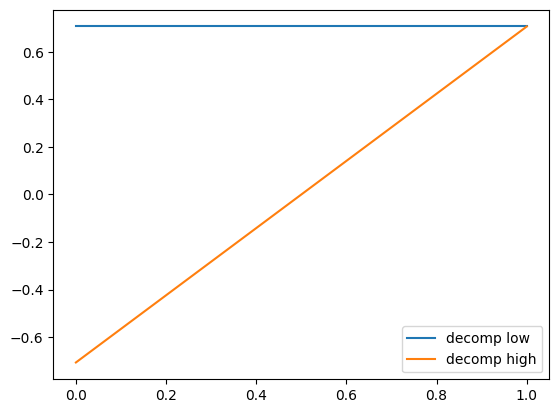

In [32]:
%matplotlib inline
wavelet = pywt.Wavelet('haar')
[dec_lo, dec_hi, rec_lo, rec_hi] = wavelet.filter_bank
print(wavelet.dec_len)

print(dec_lo)
print(dec_hi)

plt.plot(dec_lo)
plt.plot(dec_hi)
plt.legend(labels=['decomp low', 'decomp high'])
plt.show()

In [35]:
plot_wavelet_decomp(AVA_traces[10], 'haar', 10)

[array([ 2.78060154e-01,  1.11610937e-01,  5.53679120e-02,  3.71032588e-02,
         5.28859412e-02,  5.11344676e-03, -6.53539190e-03,  1.98434209e-02,
        -3.03691857e-03, -1.75355431e-03,  1.41626804e-02, -1.51069793e-02,
        -1.34100225e-02, -6.53650165e-03,  3.41995804e-03,  3.69347838e-03,
         3.93162524e-03,  4.59484359e-03,  3.43303236e-03, -7.06915019e-04,
         7.27768041e-03,  1.05528152e-02,  1.06950721e-02, -2.36256798e-02,
        -2.58959992e-02, -2.97049964e-02, -4.83467588e-02, -4.91529970e-02,
        -3.50225343e-02, -3.31341446e-02, -2.39906510e-02, -6.56228269e-02,
        -4.91194963e-02, -4.13335126e-02, -1.52483345e-02, -4.79345535e-04,
        -6.99035747e-03,  2.91893757e-03, -8.47424090e-03, -2.34175310e-02,
         2.11274094e-02,  2.02433494e-03,  4.12051276e-02,  3.84824783e-02,
         2.48879587e-02,  3.15315172e-02,  3.98015628e-02,  4.55340804e-02,
         3.73929053e-02,  3.86632299e-02,  1.24164435e-02,  4.16297483e-04,
         1.5

In [43]:
rate

1.67

In [46]:
%matplotlib qt

waveletname = 'haar'
wavelet = pywt.Wavelet(waveletname)
wavelen = wavelet.dec_len
level = 9

rate= rate
length = 1645

neurons = ['AVA', 'SMDV', 'AWC', 'ASH', 'RID']

all_traces = [AVA_traces, SMDV_traces, AWC_traces, ASH_traces, RID_traces]

df = pd.DataFrame(columns=['Neuron_name', 'DecompLevel', 'Power'])

for i, neuron in enumerate(neurons):
    for j in range(len(all_traces[i])):
        approx, detail, power = get_wavelet_decomp(np.squeeze(all_traces[i][j]), waveletname, level)
        df = pd.concat([df, pd.DataFrame([{'neuron_name': neuron, 'DecompScale': str((wavelen/rate)* 2**k)[:4], 'Power':power[k]} for k in range(len(power))])])

    '''
    AVA_approx, AVA_detail, AVA_power = get_wavelet_decomp(AVA_traces[i], waveletname, level)
    SMDV_approx, SMDV_detail, SMDV_power = get_wavelet_decomp(SMDV_traces[i], waveletname, level)
    AWC_approx, AWC_detail, AWC_power = get_wavelet_decomp(AWC_traces[i], waveletname, level)
    ASH_approx, ASH_detail, ASH_power = get_wavelet_decomp(ASH_traces[i], waveletname, level)
    RID_approx, RID_detail, RID_power = get_wavelet_decomp(RID_traces[i], waveletname, level)
    
    df = pd.concat([df, pd.DataFrame([{'neuron_name':'AVA', 'DecompLevel':2**j, 'Power':AVA_power[j]} for j in range(len(AVA_power))])])
    df = pd.concat([df, pd.DataFrame([{'neuron_name':'SMDV', 'DecompLevel':2**j, 'Power':SMDV_power[j]} for j in range(len(SMDV_power))])])
    df = pd.concat([df, pd.DataFrame([{'neuron_name':'AWC', 'DecompLevel':2**j, 'Power':AWC_power[j]} for j in range(len(AWC_power))])])
    df = pd.concat([df, pd.DataFrame([{'neuron_name':'ASH', 'DecompLevel':2**j, 'Power':ASH_power[j]} for j in range(len(ASH_power))])])
    df = pd.concat([df, pd.DataFrame([{'neuron_name':'RID', 'DecompLevel':2**j, 'Power':RID_power[j]} for j in range(len(RID_power))])])
    '''

fig, axs = plt.subplots(5,2)

for i, neuron in enumerate(neurons):
    for j in range(len(all_traces[i])):
        axs[i,0].plot(np.linspace(0,length/rate,length), all_traces[i][j][:length], alpha=0.5)
    axs[i,0].set_xlabel('Time in seconds')
    axs[i,0].set_ylabel('df/f')
    axs[i,0].title.set_text(neuron)

    sns.boxplot(ax=axs[i,1], data= df[df['neuron_name']==neuron], x='DecompScale', y='Power')
    axs[i,1].set_xlabel('Wavelet scale in seconds')
    axs[i,1].set_ylabel('Wavelet power')
    axs[i,1].title.set_text(neuron)

plt.show()

## raw images

In [65]:
filepath = '/Users/danielysprague/foco_lab/data/NWB_Ray/20221215-20-02-49.nwb'

with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
    read_nwb = io.read()
    seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
    labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
    channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
    scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

    calc_image1 = np.max(read_nwb.acquisition['CalciumImageSeries'].data[0:20, :,:,:], axis=0)
    calc_image2 = np.max(read_nwb.acquisition['CalciumImageSeries'].data[100:120, :,:,:], axis=0)
    calc_image3 = np.max(read_nwb.acquisition['CalciumImageSeries'].data[200:220, :,:,:], axis=0)
    rate = read_nwb.acquisition['CalciumImageSeries'].rate
    #fluor = read_nwb.processing['CalciumActivity']['CalciumFluorescence']['SignalCalciumImResponseSeries'].data[:]

read_nwb

root pynwb.file.NWBFile at 0x5981398608
Fields:
  acquisition: {
    CalciumImageSeries <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolumeSeries'>,
    NeuroPALImageRaw <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolume'>
  }
  devices: {
    Spinning disk confocal <class 'pynwb.device.Device'>
  }
  experiment_description: optogenetic stimulation of single neurons
  experimenter: ['Raymond Dunn']
  file_create_date: [datetime.datetime(2023, 8, 29, 14, 47, 47, 268954, tzinfo=tzoffset(None, -25200))]
  identifier: 20221215-20-02-49
  imaging_planes: {
    CalciumImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>,
    NeuroPALImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>,
    ProcessedImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>
  }
  institution: UCSF
  lab: FOCO lab
  processing: {
    CalciumActivity <class 'pynwb.base.ProcessingModule'>,
    NeuroPAL <class 'pynwb.base.ProcessingModule'>,
    ProcessedImage <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['']
  session_description: NeuroPAL and calcium imaging of immobilized worm with optogenetic stimulus
  session_start_time: 2022-12-15 20:02:49-08:00
  subject: subject abc.CElegansSubject at 0x5923432976
Fields:
  age__reference: birth
  cultivation_temp: 20.0
  date_of_birth: 2022-12-15 00:00:00-08:00
  description: NeuroPAL worm in microfluidic chip
  growth_stage: YA
  growth_stage_time: P0DT2H30M0S
  sex: O
  species: http://purl.obolibrary.org/obo/NCBITaxon_6239
  strain: FC121
  subject_id: 20221215-20-02-49

  timestamps_reference_time: 2022-12-15 20:02:49-08:00

In [52]:
print(channels.shape)

print(np.max(image))

RGB = image[:,:,:,channels[:-1]]/np.max(image)

print(np.max(RGB))

Zmax = np.max(RGB, axis=2)

plt.imshow(np.transpose(Zmax, [1,0,2]))
plt.show()

(4,)
4095
1.0


In [57]:
print(calc_image1.shape)

(1000, 240, 12)


In [66]:
fig, axs = plt.subplots(3, 1)

calc1 = np.max(calc_image1/np.max(calc_image1),axis=2)
calc2 = np.max(calc_image2/np.max(calc_image2),axis=2)
calc3 = np.max(calc_image3/np.max(calc_image3),axis=2)

axs[0].imshow(np.transpose(calc1))
axs[1].imshow(np.transpose(calc2))
axs[2].imshow(np.transpose(calc3))

plt.show()

2023-12-04 16:30:48.944 python[55407:54048270] +[CATransaction synchronize] called within transaction
2023-12-04 16:30:58.868 python[55407:54048270] +[CATransaction synchronize] called within transaction
2023-12-04 16:31:01.094 python[55407:54048270] +[CATransaction synchronize] called within transaction


## Figure 2: C. elegans extension and NWB architecture


## Table 1: Summary of collected datasetes

Columns will be: source paper, lab, number of worms, NP/GCaMP/both, average num segmented neurons, average num ID labels, notes

## Figure 3: Software pipelines for working with NWB

## Figure 4: Benchmarking performance of curated datasets on different atlases

In [72]:
'''
Call get_dataset_neurons for each data source folder that you want to process. Returns a df with all blobs across
all files in the source folder, with an additional column to show which file that blob came from

Call get_summary_stats and plot_summary_stats to get the number of segmented and IDd neurons by dataset and plot
on bar plot
'''

Yem_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/Yemini_NWB')
FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_Ray')
NP_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NP_nwb')
old_FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_foco')
chaud_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_chaudhary')
kimura_dataset = get_dataset_online('000692')
flavell_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_NP_flavell')

dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])
dict_keys(

A newer version (0.58.2) of dandi/dandi-cli is available. You are using 0.56.0
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'dorsalness': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'feedingness': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'forwardness': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data

In [73]:
def run_linear_assignment(df_data, atlas):
    #df_data should have columns 'X', 'Y', 'Z', 'R', 'G', 'B', 'ID' 

    df_assigns = df_data.copy()

    mu = atlas.mu
    sigma = atlas.sigma
    neurons = np.asarray(atlas.neurons)

    xyzrgb = np.asarray(df_data[['X','Y','Z','R','G','B']])
    gt_labels = np.asarray(df_data['ID'])

    assigns = np.empty((xyzrgb.shape[0],5),np.dtype('U100'))

    cost_mat = np.zeros((xyzrgb.shape[0], mu.shape[0]))

    for i in range(xyzrgb.shape[0]):
        for j in range(mu.shape[0]):
            cost = maha_dist(xyzrgb[i,:], mu[j,:], sigma[:,:,j])

            cost_mat[i,j] = cost

    for k in range(5):

        row_inds, col_inds = linear_sum_assignment(cost_mat)

        assigns[row_inds,k] = np.asarray(neurons[col_inds])

        cost_mat[row_inds, col_inds] = np.inf

    #figure out case where more rows than columns 

    df_assigns['assign_1'] = assigns[:,0]
    df_assigns['assign_2'] = assigns[:,1]
    df_assigns['assign_3'] = assigns[:,2]
    df_assigns['assign_4'] = assigns[:,3]
    df_assigns['assign_5'] = assigns[:,4]

    return df_assigns

In [74]:
def get_accuracies(folder, atlas):
    acc_df = pd.DataFrame(columns=['Percent_IDd', 'Percent_top1', 'Percent_top2', 'Percent_top3', 'Percent_top4', 'Percent_top5', 'Filename'])
    for file in os.listdir(folder):
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        df = run_linear_assignment(df_data, atlas)

        IDd = df[~df['ID'].isnull()]

        corr1 = df.loc[df['ID']==df['assign_1']]
        corr2 = df.loc[df['ID']==df['assign_2']]
        corr3 = df.loc[df['ID']==df['assign_3']]
        corr4 = df.loc[df['ID']==df['assign_4']]
        corr5 = df.loc[df['ID']==df['assign_5']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)
        corr_cum_5 = pd.concat([corr_cum_4, corr5]).drop_duplicates().reset_index(drop=True)

        per_ID = len(IDd.index)/len(df.index)

        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)
        per_corr_5 = len(corr_cum_5.index)/len(IDd.index)

        acc_df.loc[len(acc_df.index)] = [per_ID, per_corr_1, per_corr_2, per_corr_3, per_corr_4, per_corr_5, file[:-4]]

    return acc_df

In [126]:
'''
Pass folder containing atlas aligned values and trained atlas
Atlas training/alignment approach uses the histogram matched data

Outputs dataframe with columns 'Percent_IDd', 'Percent_top1', 'Percent_top2', 'Percent_top3', 'Percent_top4', 'Percent_top5', 'Filename'
'''

accs_NP = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_NP', NP_atlas)
accs_unsplit = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_full', NWB_atlas_full)

In [161]:
for i in range(5):
    atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_13_tr_te_split/exgroup'+str(i)+'.pkl') #Atlas trained on just original 10 NeuroPAL datasets

    accs_df_group = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_split_full/group'+str(i+1), atlas)

    if i==0:
        accs_full = accs_df_group
    else:
        accs_full = pd.concat([accs_full, accs_df_group])


In [166]:
for i in range(5):
    atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_14_2_tr_te_split/exgroup'+str(i)+'.pkl') #Atlas trained on just original 10 NeuroPAL datasets

    accs_df_group = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_split_full_2/group'+str(i+1), atlas)

    if i==0:
        accs_test = accs_df_group
    else:
        accs_test = pd.concat([accs_full, accs_df_group])


/Users/danielysprague/foco_lab/NWB/Analysis/utils.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mahal)


ValueError: matrix contains invalid numeric entries

In [ ]:
#TODO: Code for comparing histogram matching approaches. 
#Will be three paired violin plots showing assignment accuracy for each approach

In [128]:
%matplotlib qt
def plot_accuracies(datasets, accs_NP, accs_full, labels):

    df_dataset = pd.DataFrame(columns=['Atlas', 'Dataset', 'Accuracy'])
    df_ranks = pd.DataFrame(columns= ['Atlas', 'Rank', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_dataset.loc[len(df_dataset.index)] = ['NP', labels[i], acc_NP.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Consolidated', labels[i], acc_full.iloc[0]['Percent_top1']]

            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top', acc_NP.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top', acc_full.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top2', acc_NP.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top2', acc_full.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top3', acc_NP.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top3', acc_full.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top4', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top4', acc_full.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top5', acc_NP.iloc[0]['Percent_top5']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top5', acc_full.iloc[0]['Percent_top5']]

    fig, axs = plt.subplots(1,2)

    sns.set(style='white', font_scale=1.5)

    sns.violinplot(ax= axs[0], data = df_dataset, x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=['purple','pink'], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    
    for i, dataset in enumerate(labels):
        NP_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='NP')]['Accuracy']
        consol_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Consolidated')]['Accuracy']

        for a, b in zip(NP_vals, consol_vals):
            axs[0].plot([i-0.1,i+0.1], [a,b], color='black', linewidth=0.5)

    sns.violinplot(ax= axs[1], data = df_ranks, x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=['purple', 'pink'], orient='v', split=True, cut=0, inner='quart', density_norm='width') 

    ranks = ['top', 'top2', 'top3', 'top4', 'top5']

    for j, rank in enumerate(ranks):
        NP_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='NP')]['Accuracy']
        consol_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Consolidated')]['Accuracy']

        for a, b in zip(NP_vals_rank, consol_vals_rank):
            axs[1].plot([j-0.1,j+0.1], [a,b], color='black', linewidth=0.5)

    axs[0].set_ylim((0,1))
    axs[1].set_ylim((0,1))
    
    axs[0].set_title('Accuracy by dataset')
    axs[1].set_title('Cumulative accuracy of top n assignments')

    plt.show()
    
plot_accuracies([chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset, kimura_dataset, flavell_dataset], accs_NP, accs_full, ['1', '2', '3', '4', '5', '6'])

In [152]:
NP_atlas_match = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_14_NPonly.pkl') #Atlas trained on just original 10 NeuroPAL datasets
NP_atlas_unmatch = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_14_NPunmatch.pkl')

accs_NP = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_NP', NP_atlas_match)
accs_NP_unmatch = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_NP_nomatch', NP_atlas_unmatch)

In [158]:

for i in range(5):
    full_atlas_match = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_14_2_tr_te_split/exgroup'+str(i)+'.pkl') #Atlas trained on just original 10 NeuroPAL datasets
    full_atlas_unmatch = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_14_1_tr_te_split_unmatch/exgroup'+str(i)+'.pkl')

    accs_match = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_split_full_2/group'+str(i+1), atlas)
    accs_unmatch = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_split_nomatch/group'+str(i+1), atlas)

    if i==0:
        accs_full = accs_match
        accs_full_unmatch = accs_unmatch
    else:
        accs_full = pd.concat([accs_full, accs_match])
        accs_full_unmatch = pd.concat([accs_full_unmatch, accs_unmatch])


In [132]:
NP_atlas_match = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_14_NPonly.pkl')
accs_NP = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_NP', NP_atlas_match)

In [159]:
plot_accuracies([chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset, kimura_dataset, flavell_dataset], accs_NP_unmatch, accs_NP, ['1', '2', '3', '4', '5', '6'])
#plot_accuracies([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset, kimura_dataset, flavell_dataset], accs_NP_unmatch, accs_full_unmatch, ['og','1', '2', '3', '4', '5', '6'])
plot_accuracies([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset, kimura_dataset, flavell_dataset], accs_full_unmatch, accs_full, ['og','1', '2', '3', '4', '5', '6'])
#plot_accuracies([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset, kimura_dataset, flavell_dataset], accs_NP, accs_full, ['og','1', '2', '3', '4', '5', '6'])

In [120]:
plot_accuracies([chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset, kimura_dataset, flavell_dataset], accs_NP, accs_full, ['1', '2', '3', '4', '5', '6'])

In [ ]:
%matplotlib inline
import scipy.stats as stats

def plot_accuracies_atlas_compare(datasets, accs_NP, accs_full):

    df = pd.DataFrame(columns=['NeuroPAL','Consolidated', 'dataset'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            acc_NP = accs_NP[key]
            acc_full = accs_full[key]

            df.loc[len(df.index)] = [acc_NP, acc_full, key]
    
    df_long = pd.melt(df, id_vars='dataset', value_vars=['NeuroPAL', 'Consolidated'], var_name='Accuracy', value_name='Value')

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Accuracy', y='Value', data=df_long, color='skyblue', width=0.4)
    sns.boxplot(x='Accuracy', y='Value', data=df_long, color='lightcoral', width=0.4)
    sns.scatterplot(x='Accuracy', y='Value', data=df_long, color='skyblue')
    sns.scatterplot(x='Accuracy', y='Value', data=df_long, color='lightcoral')

    t, prob = stats.ttest_rel(np.asarray(df['NeuroPAL']), np.asarray(df['Consolidated']))

    plt.ylabel('Assignment accuracy')
    plt.xlabel('Atlas used')
    plt.ylim((0,1))

    print(t)
    print(prob)
    # Add lines connecting data points from the same dataset
    #for i in range(len(df)):
    #    plt.plot([i, i], [df['acc_NP'][i], df['acc_full'][i]], color='gray', linestyle='-', linewidth=1, alpha=0.7)

    plt.show()

plot_accuracies_atlas_compare([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset], accs_NP, accs_full)

## Example images

In [52]:
raw_file = '/Users/danielysprague/foco_lab/data/NP_Ray/20221215-20-02-49/full_comp.tif'
data = skio.imread(raw_file)
data = np.transpose(data)

print(data.shape)

(1000, 240, 48, 6)


In [21]:
import tifffile

#folders = ['NWB_Ray', 'NP_NWB', 'Yemini_NWB', 'NWB_chaudhary', 'NWB_foco', 'kimura_full']
#filepath = '/Users/danielysprague/foco_lab/data/NWB_Ray/20230322-18-57-04.nwb'
folders = ['NWB_NP_Flavell']

for folder in folders:
    for file in os.listdir('/Users/danielysprague/foco_lab/data/'+folder):
        if file[-4:] != '.nwb':
            continue

        print(file)
        filepath = '/Users/danielysprague/foco_lab/data/'+folder + '/' + file
        with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
            read_nwb = io.read()
            identifier = read_nwb.identifier
            seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
            labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
            channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
            image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
            scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors


        RGBW_image = image[:,:,:,channels]
        im = np.transpose(RGBW_image, (2,3,1,0))
        im = im.astype('uint16')

        tifffile.imwrite('/Users/danielysprague/foco_lab/data/example_images/'+ identifier + '.tif', im, imagej=True)

2023-01-13-07.nwb
2023-01-16-22.nwb
2022-08-02-01.nwb
2023-01-16-08.nwb
2023-01-06-08.nwb
2022-12-21-06.nwb
2023-01-09-28.nwb
2023-01-17-14.nwb
2023-01-05-01.nwb
2023-01-17-01.nwb
2023-01-09-15.nwb
2022-07-15-12.nwb
2022-07-15-06.nwb
2023-01-17-07.nwb
2023-01-23-01.nwb
2023-01-23-15.nwb
2023-01-19-15.nwb
2022-07-26-01.nwb
2023-01-10-14.nwb
2022-06-14-13.nwb
2022-06-14-07.nwb
2023-01-09-08.nwb
2023-01-09-22.nwb
2023-01-19-22.nwb
2022-06-14-01.nwb
2023-01-10-07.nwb
2023-01-23-08.nwb
2023-01-05-18.nwb
2023-01-23-21.nwb
2023-01-19-08.nwb
2022-06-28-07.nwb
2023-01-16-15.nwb
2023-01-16-01.nwb
2022-07-20-01.nwb
2023-01-06-01.nwb
2023-01-18-01.nwb
2022-06-28-01.nwb
2023-03-07-01.nwb


In [54]:
for file in os.listdir('/Users/danielysprague/foco_lab/data/hist_matched'):
    filepath = '/Users/danielysprague/foco_lab/data/hist_matched/' + file

    imfile = sio.loadmat(filepath)
    im = np.transpose(imfile['data_matched'], [2,3,0,1])
    im = im.astype('uint16')

    tifffile.imwrite('/Users/danielysprague/foco_lab/data/example_histmatch/' + file[:-4]+'.tif', im, imagej=True)


In [52]:
import shutil

for file in os.listdir('/Users/danielysprague/foco_lab/data/hist_matched'):
    if file[-4:] == '.tif':
        shutil.move('/Users/danielysprague/foco_lab/data/hist_matched/'+file, '/Users/danielysprague/foco_lab/data/example_histmatch/'+file)

In [16]:
read_nwb

root pynwb.file.NWBFile at 0x11485667472
Fields:
  devices: {
    NIR Config <class 'pynwb.device.Device'>,
    Spinning Disk Confocal <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2023, 12, 12, 17, 41, 51, 890148, tzinfo=tzoffset(None, -28800))]
  identifier: 2023-01-19 00:00:00
  institution: MIT
  lab: Flavell Laboratory
  processing: {
    Behavior <class 'pynwb.base.ProcessingModule'>,
    NeuroPAL <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['https://doi.org/10.1016/j.cell.2023.07.035']
  session_description: Ventral cord on top when head faces left; 2-3 mature eggs
This is a baseline dataset
High pumping variance, lots of turns and reversals throughout the 1600 timepoints
Long coilings x2 with mild focus issue in t>1500
Laid 2 eggs during immobilization
02, 03, 04, 06 should register reasonably well, but 05 and 07 have more gliding than what I’d like to see

  session_start_time: 2023-01-19 00:00:00-08:00
  subject: subject abc.CElegansSubject at 0x11747255184
Fields:
  age__reference: birth
  cultivation_temp: 22.0
  date_of_birth: 2023-01-19 00:00:00-08:00
  description: Ventral cord on top when head faces left; 2-3 mature eggs
This is a baseline dataset
High pumping variance, lots of turns and reversals throughout the 1600 timepoints
Long coilings x2 with mild focus issue in t>1500
Laid 2 eggs during immobilization
02, 03, 04, 06 should register reasonably well, but 05 and 07 have more gliding than what I’d like to see

  growth_stage: young adult
  growth_stage_time: nan
  sex: hermaphrodite
  species: C. Elegans
  strain: SWF702
  subject_id: 2023-01-19 00:00:00-SWF702

  timestamps_reference_time: 2023-01-19 00:00:00-08:00

## Figure 5: Summary statistics of datasets

In [7]:
'''
Pass datasets generated by get_dataset_neurons to combine datasetes. Can pass any number of datasets as 
list elements. This will preserve which file each neuron comes from but not which original folder
'''

tot_dataset = combine_datasets([Yem_dataset, FOCO_dataset, NP_dataset, old_FOCO_dataset, chaud_dataset, kimura_dataset])
print(tot_dataset.keys())

dict_keys(['20190928_08', '20190929_02', '20190929_03', '20190925_01', '20191030_07', '20190925_04', '20191030_03', '20190929_05', '20190929_07', '20190929_06', '20191104_10', '20191104_08', '20190924_01', '20190928_01', '20190928_03', '20190924_03', '20190924_02', '20190928_13', '20190928_07', '20190928_11', '20190928_05', '20230412-20-15-17', '20230506-14-24-57', '20230510-13-25-46', '20230322-22-43-03', '20221106-21-47-31', '20230506-12-56-00', '20221106-21-00-09', '20230322-20-16-50', '20221028-18-48-00', '20230506-13-32-08', '20230510-16-36-46', '20230506-15-33-51', '20230510-15-49-47', '20221215-20-02-49', '20230322-21-41-10', '20221106-21-23-19', '20230506-15-01-45', '20230510-12-53-34', '20221215-22-02-55', '20230322-18-57-04', '56_YAaDV', '38_YAaDV', '76_YAaDV', '11_YAaLR', '64_YAaDV', '70_YAaLR', '55_YAaDV', '7_YAaLR', '62_YAaLR', '20_YAaLR', '2021-12-03-w00-NP1', '2022-03-05-w00-NP1', '2022-02-12-w00-NP1', '2022-02-22-w04-NP1', '2022-02-11-w03-NP1', '2022-02-12-w01-NP1', '20

In [24]:
seg = []
ID = []

for dataset in [Yem_dataset, FOCO_dataset, NP_dataset, old_FOCO_dataset, chaud_dataset, kimura_dataset]:
    num_seg = np.zeros(len(dataset.keys()))
    num_ID = np.zeros(len(dataset.keys()))
    for i, key in enumerate(dataset.keys()):
        value = dataset[key]
        segmented = len(value)
        IDd = value[value['ID']!='']
        num_ID[i] = len(IDd)
        num_seg[i] = segmented

    seg.append(num_seg)
    ID.append(num_ID)


<bound method NDFrame.head of        x    y   z    R     G     B          xr         yr    zr    ID
0     18  100  10  492   968  1153    4.800000  26.666667  15.0   I1R
1     22  133  12  581   931  1261    5.866667  35.466667  18.0   I1L
2     76   85   6  544   114   467   20.266667  22.666667   9.0   I2R
3     78  166  12  565   113   462   20.800000  44.266667  18.0   I2L
4     79   86  18  480     0   333   21.066667  22.933333  27.0    MI
..   ...  ...  ..  ...   ...   ...         ...        ...   ...   ...
178  485  179   5  358  1046  1013  129.333333  47.733333   7.5   DD1
179  493  188   5  137   258  1320  131.466667  50.133333   7.5   VD1
180  500  180   7  150   194   514  133.333333  48.000000  10.5  RIGR
181  500  170   5  127   803   362  133.333333  45.333333   7.5   AVG
182  508  183   5  548   137   336  135.466667  48.800000   7.5   VA1

[183 rows x 10 columns]>
<bound method NDFrame.head of        x    y   z     R     G     B          xr         yr    zr     ID
0 

In [25]:
print('Yemini dataset')
print('Average segmented: ' + str(np.mean(seg[0])))
print('Average IDd: ' + str(np.mean(ID[0])))
print('Min segmented: ' + str(np.min(seg[0])))
print('Max segmented: ' + str(np.max(seg[0])))
print('Min IDd: ' + str(np.min(ID[0])))
print('Max IDd: ' + str(np.max(ID[0])))

print('FOCO dataset')
print('Average segmented: ' + str(np.mean(seg[1])))
print('Average IDd: ' + str(np.mean(ID[1])))
print('Min segmented: ' + str(np.min(seg[1])))
print('Max segmented: ' + str(np.max(seg[1])))
print('Min IDd: ' + str(np.min(ID[1])))
print('Max IDd: ' + str(np.max(ID[1])))

print('old FOCO dataset')
print('Average segmented: ' + str(np.mean(seg[3])))
print('Average IDd: ' + str(np.mean(ID[3])))
print('Min segmented: ' + str(np.min(seg[3])))
print('Max segmented: ' + str(np.max(seg[3])))
print('Min IDd: ' + str(np.min(ID[3])))
print('Max IDd: ' + str(np.max(ID[3])))

print('Chaudhary dataset')
print('Average segmented: ' + str(np.mean(seg[4])))
print('Average IDd: ' + str(np.mean(ID[4])))
print('Min segmented: ' + str(np.min(seg[4])))
print('Max segmented: ' + str(np.max(seg[4])))
print('Min IDd: ' + str(np.min(ID[4])))
print('Max IDd: ' + str(np.max(ID[4])))

print('Kimura dataset')
print('Average segmented: ' + str(np.mean(seg[5])))
print('Average IDd: ' + str(np.mean(ID[5])))
print('Min segmented: ' + str(np.min(seg[5])))
print('Max segmented: ' + str(np.max(seg[5])))
print('Min IDd: ' + str(np.min(ID[5])))
print('Max IDd: ' + str(np.max(ID[5])))

Yemini dataset
Average segmented: 177.42857142857142
Average IDd: 175.04761904761904
Min segmented: 166.0
Max segmented: 188.0
Min IDd: 164.0
Max IDd: 184.0
FOCO dataset
Average segmented: 108.9
Average IDd: 32.05
Min segmented: 82.0
Max segmented: 131.0
Min IDd: 5.0
Max IDd: 54.0
old FOCO dataset
Average segmented: 173.2
Average IDd: 49.3
Min segmented: 166.0
Max segmented: 180.0
Min IDd: 38.0
Max IDd: 63.0
Chaudhary dataset
Average segmented: 118.77777777777777
Average IDd: 64.33333333333333
Min segmented: 113.0
Max segmented: 125.0
Min IDd: 58.0
Max IDd: 69.0
Kimura dataset
Average segmented: 154.22222222222223
Average IDd: 154.22222222222223
Min segmented: 149.0
Max segmented: 163.0
Min IDd: 149.0
Max IDd: 163.0


In [8]:
pair_NP = get_pairings(NP_dataset)
pair_tot = get_pairings(tot_dataset)

In [70]:
def get_neur_nums(tot_dataset, atlas):

    neur_IDs = atlas.df['ID']

    num_datasets = len(tot_dataset.keys())
    neurons = {k:0 for k in neur_IDs}

    for dataset in tot_dataset.keys():
        blobs = tot_dataset[dataset]

        for i, row in blobs.iterrows():
            ID = row['ID']
            if ID == '':
                continue

            if not ID in neurons:
                neurons[ID] = 1

            else:
                neurons[ID] += 1

    return neurons, num_datasets

def plot_neur_nums(neurons, num_datasets, atlas):

    neur_df = atlas.df[['ID', 'ganglion']]

    dict_df = pd.DataFrame(list(neurons.items()), columns = ['ID', 'num'])
    dict_df['frac'] = dict_df['num']/num_datasets
 
    merged = pd.merge(neur_df, dict_df, on='ID') #this will preserve the order of neurons from neur_df which is sorted by ganglion and then distance along x axis

    sns.set(style='whitegrid')

    plt.figure(figsize=(12,8))
    sns.barplot(x='ID', y='frac', hue='ganglion', data=merged)

    plt.xlabel('Neuron IDs')
    plt.ylabel('Fraction of datasets with ground truth labeled neuron')

    plt.xticks(rotation=60, ha='right', fontsize=6)

    bar_width = 1

    for patch in plt.gca().patches:
        current_width = patch.get_width()
        diff = current_width - bar_width

        # Change the bar width
        patch.set_width(bar_width)

        # Recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

    # Show the plot
    plt.legend(title='ganglion', loc='upper right')

    plt.show()




In [24]:
'''
Plot the fraction of datasets with ground truth label for each neuron
'''

neurons, num = get_neur_nums(tot_dataset, NWB_atlas)
plot_neur_nums(neurons, num, NWB_atlas)

TypeError: 'NoneType' object is not subscriptable

In [211]:
'''
Plot the heatmap of pairwise standard deviations for the whole dataset

TODO: possibly add plot for just the NP atlas original data to show comparison 
'''

df = NWB_atlas.get_df()

num_pair, num_heatmap, total_std_heatmap = analyze_pairs(pair_tot, df, len(tot_dataset.keys()))
plot_std_heatmap(num_heatmap, total_std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

num_pair_NP, num_heatmap_NP, total_std_heatmap_NP = analyze_pairs(pair_NP, df, len(NP_dataset.keys()))
plot_std_heatmap(num_heatmap_NP, total_std_heatmap_NP, df)
plot_num_heatmap(num_heatmap_NP, df)

In [30]:
def get_ganglia_variance(atlas_df, pairs, num_neighbors):

    ganglia = {}
    visited_pair = []
    X = np.asarray(atlas_df[['X','Y','Z']])
    neighbors = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto')

    neighbors.fit(X)

    neighbor_dists, neighbor_index = neighbors.kneighbors(X=X, return_distance = True)

    for i, row in atlas_df.iterrows():
        neighbors = neighbor_index[i,1:]
        neighb_dists = neighbor_dists[i, 1:]
        ID = row['ID']
        ganglion = row['ganglion']
        for j, neighbor in enumerate(neighbors):
            n_ID = atlas_df.loc[neighbor, 'ID']
            n_gang = atlas_df.loc[neighbor, 'ganglion']
            if ganglion < n_gang:
                gang_pair = ganglion + '-' + n_gang
            else:
                gang_pair = n_gang + '-' + ganglion

            if ID == n_ID:
                break
            elif ID < n_ID:
                pair = ID + '-' + n_ID
            else:
                pair = n_ID + '-' + ID

            if pair in pairs.keys() and pair not in visited_pair:
                pair_dists = pairs[pair]
                pair_std = np.std(pair_dists)

                if not gang_pair in ganglia.keys():
                    ganglia[gang_pair] = [pair_std]
                else:
                    ganglia[gang_pair].append(pair_std)

                visited_pair.append(pair)

    return ganglia

ganglia = get_ganglia_variance(NWB_atlas.get_df(), pair_tot, 10)

NameError: name 'pair_tot' is not defined

In [ ]:
def plot_ganglion_variance(ganglia):

    abbrevs = {'Anterior Pharyngeal Bulb':'AntBulb', 'Anterior Ganglion':'Ant', 'Dorsal Ganglion':'Dors', 'Lateral Ganglion':'Lat', 'Ventral Ganglion':'Vent', 'Retro Vesicular Ganglion':'RVG', 'Posterior Pharyngeal Bulb':'PostBulb','other':'Oth'}
    order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Vent','Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent']

    data = {'abbrev':[], 'ganglion1':[], 'ganglion2':[], 'value':[], 'intra':[]}

    for key,values in ganglia.items():
        ganglion1, ganglion2 = key.split('-')

        if len(values)<5:
            continue

        for value in values:
            if ganglion1 =='other' or ganglion2 =='other':
                continue
            data['abbrev'].append(abbrevs[ganglion1] + '-' +abbrevs[ganglion2])
            data['ganglion1'].append(ganglion1)
            data['ganglion2'].append(ganglion2)
            data['value'].append(value)
            data['intra'].append(ganglion1 == ganglion2)



    df = pd.DataFrame(data)
    
    print(df.head())

    sns.set(style='whitegrid')
    fig, axs = plt.subplots(figsize=(20,6))

    g1 = sns.barplot(ax=axs, data= df, order=order, x='abbrev', y='value', hue='intra', dodge=False, alpha=0.5, errorbar=None)
    g2 = sns.stripplot(ax=axs, data=df, order=order,x='abbrev',y='value', hue='intra', dodge=False, legend=False)
    axs.set_ylabel('Standard Deviation in um')
    axs.set_xlabel(None)
    plt.xticks(rotation='vertical')
    plt.title('Intra and inter ganglion standard deviation of 10 closest atlas neighbors')
    plt.tight_layout()

    plt.show()

plot_ganglion_variance(ganglia)    

In [ ]:
def plot_sum_heatmap(heatmap,df):

    avg_std = np.sum(heatmap,axis=0)/heatmap.shape[0]

    new_df = df.copy()

    new_df['std'] = avg_std
    print(len(avg_std))
    print(len(np.asarray(new_df['ganglion'])))

    bar = sns.catplot(data=new_df, y='ID', x='std', hue='ganglion', kind='bar',orient='h', dodge=False)

    bar.set(yticklabels=[])

    #plt.legend([],[], frameon=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()

    return np.asarray(new_df['std'])
    

stds = plot_sum_heatmap(total_std_heatmap, atlas.get_df())

## Lineage plots

In [72]:
lin_df = pd.read_csv('/Users/danielysprague/foco_lab/data/worm_lineage.csv')
lin_df.loc[lin_df['#cellName']=='hmc', '#cellName'] = 'HMC'
lin_df.loc[lin_df['#cellName']=='AMsoR', '#cellName'] = 'AMSOR'
lin_df.loc[lin_df['#cellName']=='AMsoL', '#cellName'] = 'AMSOL'
lin_df.head()

#cellName linealName parentLinealName birthTimeInMin deathTimeInMin  \
0       ABa        ABa               AB             17             \N   
1      ABal       ABal              ABa             35             \N   
2     ABala      ABala             ABal             50             \N   
3    ABalaa     ABalaa            ABala             68             \N   
4   ABalaaa    ABalaaa           ABalaa             94             \N   

  cellType description   sex  
0      NaN         NaN  herm  
1      NaN         NaN  herm  
2      NaN         NaN  herm  
3      NaN         NaN  herm  
4      NaN         NaN  herm

In [73]:
print(max(np.asarray(lin_df.loc[lin_df['#cellName']!='P0']['birthTimeInMin']).astype('int')))

3020


In [71]:
print(len('asdf'))

4


In [147]:
def find_last_shared_neuron(neuron1, neuron2, lin_df):
    # Find the last shared neuron in the lineage between two neurons

    linealName1 = lin_df.loc[lin_df['#cellName']==neuron1]['linealName'].iloc[0]
    linealName2 = lin_df.loc[lin_df['#cellName']==neuron2]['linealName'].iloc[0]
    
    if linealName1[0:2] == 'G1':
        linealName1 = 'ABprpaaaapa'+linealName1[2]

    elif linealName1[0] == 'W' and linealName2[0]!='W':
        linealName1 = 'ABprapaapa' + linealName1[1:]

    if linealName2[0:2] == 'G1':
        linealName1 = 'ABprpaaaapa'+linealName2[2]

    elif linealName2[0] == 'W' and linealName2[0]!='W':
        linealName2 = 'ABprapaapa' + linealName2[1:]

    min_len = min(len(linealName1), len(linealName2))

    # Iterate through the characters until a mismatch is found
    last_shared = ''
    last_shared_index=0
    for i in range(min_len):
        if linealName1[i] == linealName2[i]:
            last_shared += linealName1[i]
            last_shared_index=i
        else:
            break

    if linealName1==linealName2:
        last_shared_birth = max(np.asarray(lin_df.loc[lin_df['#cellName']!='P0']['birthTimeInMin']).astype('int')) #if same neuron, set birht time to max
    elif len(last_shared)==0 or last_shared=='AB': #AB is original embryo cell so will have birth time 0
        last_shared_birth=0
    elif last_shared =='W':
        last_shared_birth = lin_df.loc[lin_df['#cellName']==last_shared]['birthTimeInMin'].iloc[0]
    #elif last_shared =='G': 
    #    last_shared = 'ABp'
    #    last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]
    #elif not (lin_df['linealName']==last_shared).any(): #For G1 and G2, cell name is referenced rather than lineal name of parent
    #    last_shared = lin_df.loc[lin_df['#cellName']==last_shared]
    #    last_shared_birth = lin_df.loc[lin_df['#cellName']==last_shared]['birthTimeInMin'].iloc[0]
    else:
        last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]

    tree_distance = len(linealName1[last_shared_index+1:]) + len(linealName2[last_shared_index+1:])

    return last_shared, last_shared_birth, tree_distance


In [108]:
print(lin_df.loc[lin_df['#cellName']=='W']['birthTimeInMin'])

823    225
Name: birthTimeInMin, dtype: object


In [148]:
last_shared, last_shared_birth, tree_distance = find_last_shared_neuron('I3', 'NSMR', lin_df)
print(last_shared)
print(tree_distance)


MSaaaaapaa
ABaraapppaav
20

20


In [118]:
linealName1 = lin_df.loc[lin_df['#cellName']=='RMHL']['linealName'].iloc[0]
linealName2 = lin_df.loc[lin_df['#cellName']=='RMHR']['linealName'].iloc[0]

print(linealName1)
print(linealName2)

min_len = min(len(linealName1), len(linealName2))

last_shared=''
for i in range(min_len):
    if linealName1[i] == linealName2[i]:
        last_shared += linealName1[i]
    else:
        break

print(last_shared)

G1l
G1r
G1


In [145]:
def get_lin_dist_df(pair_tot):
    pairs = np.asarray([key for key in pair_tot.keys()])
    means = np.asarray([np.mean(value) for key, value in pair_tot.items()])
    stds = np.asarray([np.std(value) for key, value in pair_tot.items()])
    norm_stds = np.divide(stds, means, out=np.zeros_like(stds), where=means!=0)
    norm_stds

    last_shared_list = ['']*len(pairs)
    first_neurs = ['']*len(pairs)
    second_neurs = ['']*len(pairs)
    lineal_dists = np.zeros(len(pairs))
    birth_dists = np.zeros(len(pairs))
    tree_dists = np.zeros(len(pairs))

    for i, pair in enumerate(pairs):
        neuron1 = pair.split('-')[0]
        neuron2 = pair.split('-')[1]

        if neuron1[-1] =='?':
            neuron1 = neuron1[:-1]
        if neuron2[-1] == '?':
            neuron2 = neuron2[:-1]

        first_neurs[i] = neuron1
        second_neurs[i] = neuron2
        last_shared, last_shared_birth, tree_distance = find_last_shared_neuron(neuron1, neuron2, lin_df)
        last_shared_list[i] = last_shared
        lineal_dists[i] = len(last_shared)
        birth_dists[i] = last_shared_birth
        tree_dists[i] = tree_distance

    lin_dist_vals = np.transpose(np.vstack((pairs, first_neurs, second_neurs, means, stds, norm_stds, last_shared_list, lineal_dists, birth_dists, tree_dists)))

    lin_dist_df = pd.DataFrame(lin_dist_vals, columns = ['Pair', 'neuron1', 'neuron2', 'Mean_dist', 'Std_dist', 'Norm_std', 'last_shared', 'lin_dist', 'birth_dists', 'tree_dists'])
    lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']] = lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']].astype('float')
    lin_dist_df.to_csv('/Users/danielysprague/foco_lab/data/lin_dist.csv')

    return lin_dist_df

lin_dist_df = get_lin_dist_df(pair_tot)

ABarapappaa
ABarapappaa
0
ABarapappaa
ABalpapppaa
16
ABalpapppaa
ABarapappaa
16
ABarapappaa
ABarapapaapa
7
ABarapapaapa
ABarapappaa
7
ABarapappaa
ABalpappaapa
17
ABalpappaapa
ABarapappaa
17
ABarapappaa
ABaraappaaa
12
ABaraappaaa
ABarapappaa
12
ABarapappaa
ABarapaappp
8
ABarapaappp
ABarapappaa
8
ABarapappaa
ABalpaaappp
16
ABalpaaappp
ABarapappaa
16
ABarapappaa
MSaaaaapaa
19
MSaaaaapaa
ABarapappaa
19
ABarapappaa
ABaraapppaav
13
ABaraapppaav
ABarapappaa
13
ABarapappaa
ABaraapapaav
13
ABaraapapaav
ABarapappaa
13
ABarapappaa
ABarapppppp
10
ABarapppppp
ABarapappaa
10
ABarapappaa
ABalappppap
16
ABalappppap
ABarapappaa
16
ABarapappaa
ABalapappap
16
ABalapappap
ABarapappaa
16
ABarapappaa
MSpaaaaaa
18
MSpaaaaaa
ABarapappaa
18
ABarapappaa
ABalaappppp
16
ABalaappppp
ABarapappaa
16
ABarapappaa
ABplaaaaaaa
18
ABplaaaaaaa
ABarapappaa
18
ABarapappaa
ABaraappppp
12
ABaraappppp
ABarapappaa
12
ABarapappaa
ABarpapaaaa
14
ABarpapaaaa
ABarapappaa
14
ABarapappaa
ABalppapppp
16
ABalppapppp
ABarapappaa
16
ABar

In [ ]:
lin_dist_plot.to_csv('/Users/danielysprague/foco_lab/data/lin_dist_plot.csv')

In [132]:
%matplotlib qt

lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

plt.clf()
fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
norm_std = np.asarray(lin_dist_plot['Norm_std'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Std_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Standard deviation of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Standard deviation in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)

plt.show()

In [138]:
%matplotlib qt

lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
norm_std = np.asarray(lin_dist_plot['Norm_std'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Norm_std')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Standard deviation of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Nomralized standard deviation in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)

plt.show()

In [140]:
lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

fig = plt.figure()

fontsize=16

tree_dists = np.asarray(lin_dist_plot['tree_dists'])
norm_std = np.asarray(lin_dist_plot['Norm_std'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='tree_dists',y='Norm_std')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Standard deviation of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Nomralized standard deviation in um', fontsize=fontsize)
plt.xlabel('Lineal tree distance', fontsize=fontsize)

plt.show()

In [155]:
lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

fig = plt.figure()

fontsize=16

tree_dists = np.asarray(lin_dist_plot['tree_dists'])
std = np.asarray(lin_dist_plot['Std_dist'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='tree_dists',y='Std_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.gca().invert_xaxis()
plt.title('Standard deviation of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Standard deviation in um', fontsize=fontsize)
plt.xlabel('Lineal tree distance', fontsize=fontsize)

plt.show()

In [161]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

x = tree_dists.reshape((-1,1))
y = std
model = model.fit(x, y)

r_sq = model.score(x,y)
print('R2 value = '+ str(r_sq))
print('y ='+str(model.coef_[0])+'*x + '+str(model.intercept_))


R2 value = 0.0009031242852302057
y =0.04222370555246832*x + 7.272090093323904


In [162]:
lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

fig = plt.figure()

fontsize=16

tree_dists = np.asarray(lin_dist_plot['tree_dists'])
mean = np.asarray(lin_dist_plot['Mean_dist'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='tree_dists',y='Mean_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.gca().invert_xaxis()
plt.title('Mean of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Mean distance in um', fontsize=fontsize)
plt.xlabel('Lineal tree distance', fontsize=fontsize)

plt.show()

In [163]:
model = LinearRegression()

x = tree_dists.reshape((-1,1))
y = mean
model = model.fit(x, y)

r_sq = model.score(x,y)
print('R2 value = '+ str(r_sq))
print('y ='+str(model.coef_[0])+'*x + '+str(model.intercept_))


R2 value = 0.034088388595417296
y =1.6820884290724964*x + 14.013730422708829


In [164]:
lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
std = np.asarray(lin_dist_plot['Std_dist'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Std_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Standard deviation of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Standard deviation in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)

plt.show()

In [165]:
model = LinearRegression()

x = birth_dists.reshape((-1,1))
y = std
model = model.fit(x, y)

r_sq = model.score(x,y)
print('R2 value = '+ str(r_sq))
print('y ='+str(model.coef_[0])+'*x + '+str(model.intercept_))


R2 value = 0.0036110897031437217
y =-0.008535293402397257*x + 8.119547235855999


In [ ]:
lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
mean = np.asarray(lin_dist_plot['Mean_dist'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Mean_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Mean of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Mean distance in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)

plt.show()

In [166]:
model = LinearRegression()

x = birth_dists.reshape((-1,1))
y = mean
model = model.fit(x, y)

r_sq = model.score(x,y)
print('R2 value = '+ str(r_sq))
print('y ='+str(model.coef_[0])+'*x + '+str(model.intercept_))


R2 value = 0.013074390082278176
y =-0.10531083074953948*x + 43.66498010322287


In [151]:
lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_df.loc[lin_dist_df['birth_dists']<800]

fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
norm_std = np.asarray(lin_dist_plot['Norm_std'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Mean_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Mean of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Mean distance in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'invert_xaxis'

In [21]:
order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Dors', 'Ant-Lat', 'Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent','Postbulb-RVG']

In [22]:
df = pd.DataFrame()

for key, value in sorted(ganglia.items()):
    print(key)
    print(len(value))

Anterior Ganglion-Anterior Ganglion
191
Anterior Ganglion-Anterior Pharyngeal Bulb
23
Anterior Ganglion-Dorsal Ganglion
1
Anterior Ganglion-Lateral Ganglion
1
Anterior Ganglion-Ventral Ganglion
9
Anterior Pharyngeal Bulb-Anterior Pharyngeal Bulb
59
Anterior Pharyngeal Bulb-other
16
Dorsal Ganglion-Dorsal Ganglion
11
Dorsal Ganglion-Lateral Ganglion
26
Dorsal Ganglion-other
5
Lateral Ganglion-Lateral Ganglion
312
Lateral Ganglion-Posterior Pharyngeal Bulb
41
Lateral Ganglion-Retro Vesicular Ganglion
27
Lateral Ganglion-Ventral Ganglion
53
Lateral Ganglion-other
5
Posterior Pharyngeal Bulb-Posterior Pharyngeal Bulb
11
Posterior Pharyngeal Bulb-Retro Vesicular Ganglion
1
Posterior Pharyngeal Bulb-Ventral Ganglion
12
Retro Vesicular Ganglion-Retro Vesicular Ganglion
82
Retro Vesicular Ganglion-Ventral Ganglion
22
Ventral Ganglion-Ventral Ganglion
135
other-other
1


### Color statistics of datasets

In [27]:
def get_color_stats(folder):

    rgbhist = np.zeros((32,3))

    neur_colors = {}

    for file in os.listdir(folder):
        if not file[-4:] == '.nwb':
            continue

        print(file)

        blobs, rgb_data = get_nwb_neurons(folder+'/'+file)

        color_norm = (rgb_data - np.min(rgb_data, axis=(0,1,2))) / (np.max(rgb_data, axis=(0,1,2))- np.min(rgb_data, axis=(0,1,2)))

        blobs[['Rnorm', 'Gnorm','Bnorm']] = np.nan

        for i, row in blobs.iterrows():
            colors = color_norm[max(row['x']-2,0):min(row['x']+2,rgb_data.shape[0]-1),max(row['y']-2,0):min(row['y']+2,rgb_data.shape[1]-1),max(row['z']-1,0):min(row['z']+1,rgb_data.shape[2]-1),:]

            flat_colors = colors.reshape(-1, colors.shape[-1])
            
            Rnorm = np.median(flat_colors[0])
            Gnorm = np.median(flat_colors[1])
            Bnorm = np.median(flat_colors[2])

            blobs.loc[i, 'Rnorm'] = Rnorm
            blobs.loc[i, 'Gnorm'] = Gnorm
            blobs.loc[i, 'Bnorm'] = Bnorm

        IDd = blobs[blobs['ID']!='']

        for i, row in IDd.iterrows():
            ID = row['ID']
            colors = np.asarray(row[['Rnorm', 'Gnorm', 'Bnorm']])
            if not ID in neur_colors:
                neur_colors[ID] = [colors]
            else:
                neur_colors[ID].append(colors)
            
        image = np.asarray(color_norm)
        im_flat = image.reshape(-1, image.shape[-1])

        rhist, bins = np.histogram(im_flat[:,0], bins=32, range=(0,1))
        ghist, bins = np.histogram(im_flat[:,1], bins=32, range=(0,1))
        bhist, bins = np.histogram(im_flat[:,2], bins=32, range=(0,1))

        rgbhist[:,0] += rhist
        rgbhist[:,1] += ghist
        rgbhist[:,2] += bhist
    
    rgbhist[:,0] = rgbhist[:,0]/np.sum(rgbhist[:,0])
    rgbhist[:,1] = rgbhist[:,1]/np.sum(rgbhist[:,1])
    rgbhist[:,2] = rgbhist[:,2]/np.sum(rgbhist[:,2])

    return rgbhist, neur_colors

In [28]:
foco_rgb, foco_colors = get_color_stats('/Users/danielysprague/foco_lab/data/NWB_Ray')
yem_rgb, yem_colors = get_color_stats('/Users/danielysprague/foco_lab/data/Yemini_NWB')
foco_og_rgb, foco_og_colors = get_color_stats('/Users/danielysprague/foco_lab/data/')


20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-14-24-57.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-13-32-08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-16-36-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-22-02-55.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


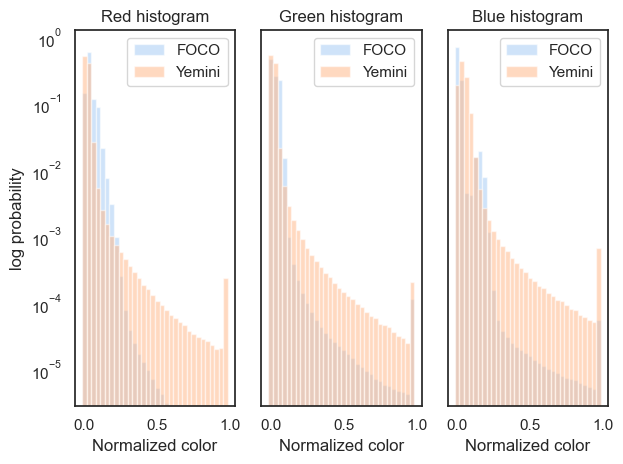

In [29]:
def plot_histograms(dataset_rgbs, labels):

    sns.set(style="white")
    fig, axs = plt.subplots(1,3, sharey=True)

    # Plot the bars using Matplotlib

    bin_edges = np.arange(32)/32

    for i, ax in enumerate(axs):
        #ax.hist(im_flat[:,i], bins= np.arange(32)/32, color= 'red')
        for j, dataset in enumerate(dataset_rgbs):
            ax.bar(bin_edges[:], dataset[:,i], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[j], log=True, label=labels[j])
            #ax.bar(bin_edges[:], yem_rgb[:,0], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[1], log=True, label='Yemini')
        ax.legend()
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(foco_rgb[:,i]), bins= np.arange(32)/32, alpha=0.3, stat = 'probability', log_scale=(False,True), label='FOCO')
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(yem_rgb[:,i]), bins=np.arange(32)/32, alpha=0.3, stat = 'probability',log_scale=(False,True), label='Yemini')

    axs[0].set_title('Red histogram')
    axs[0].set_xlabel('Normalized color')
    axs[0].set_ylabel('log probability')
    axs[1].set_title('Green histogram')
    axs[1].set_xlabel('Normalized color')
    axs[2].set_title('Blue histogram')
    axs[2].set_xlabel('Normalized color')

    plt.tight_layout()
    plt.show()

plot_histograms([foco_rgb, yem_rgb], ['FOCO', 'Yemini'])

In [30]:
color_discrim_FOCO = get_color_discrim('/Users/danielysprague/foco_lab/data/NWB_Ray', 6)
color_discrim_Yemini = get_color_discrim('/Users/danielysprague/foco_lab/data/Yemini_NWB', 6)


20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-14-24-57.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-13-32-08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-16-36-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-22-02-55.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [64]:
color_discrim_FOCO_og = get_color_discrim('/Users/danielysprague/foco_lab/data/NWB_foco', 6)
color_discrim_NP = get_color_discrim('/Users/danielysprague/foco_lab/data/NP_nwb', 6)

2021-12-03-w00-NP1.nwb
2022-03-05-w00-NP1.nwb
2022-02-12-w00-NP1.nwb
2022-02-22-w04-NP1.nwb
2022-02-11-w03-NP1.nwb
2022-02-12-w01-NP1.nwb
2022-01-22-w04-NP1.nwb
2022-04-26-w01-NP1.nwb
2022-04-26-w00-NP1.nwb
2022-04-01-w00-NP1.nwb
56_YAaDV.nwb
38_YAaDV.nwb
76_YAaDV.nwb
11_YAaLR.nwb
64_YAaDV.nwb
70_YAaLR.nwb
55_YAaDV.nwb
7_YAaLR.nwb
62_YAaLR.nwb
20_YAaLR.nwb


In [73]:
df = pd.DataFrame({'avg_col_discrim': 5.3, 'identifier':'asdf'})

print(df)


ValueError: If using all scalar values, you must pass an index

In [78]:
color_df = pd.DataFrame(columns=['avg_col_discrim', 'identifier'])

datasets= [color_discrim_FOCO, color_discrim_Yemini, color_discrim_FOCO_og, color_discrim_NP]

for dataset in datasets:
    for key, value in dataset.items():
        color_df = pd.concat([color_df, pd.DataFrame({'avg_col_discrim': np.mean(value), 'identifier':key[:-4]}, index=[0])], ignore_index=True)

print(color_df)

    avg_col_discrim         identifier
0          0.233278  20230412-20-15-17
1          0.182110  20230506-14-24-57
2          0.275786  20230510-13-25-46
3          0.145156  20230322-22-43-03
4          0.163429  20221106-21-47-31
..              ...                ...
56         1.837451           70_YAaLR
57         2.101219           55_YAaDV
58         1.792815            7_YAaLR
59         1.785512           62_YAaLR
60         2.016502           20_YAaLR

[61 rows x 2 columns]


In [65]:
plot_color_discrim([color_discrim_FOCO, color_discrim_Yemini, color_discrim_FOCO_og, color_discrim_NP], ['FOCO', 'Yemini', 'FOCO_og', 'NP'])

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


## Figure 4: Benchmarking performance of consolidated datasets 

All experiments run using consolidated dataset, different image processing approaches, box-whisker plot similar to above

In [32]:
atlas_df = atlas.get_df()
atlas_df

gt = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_paper/all/11_YAaLR.csv', skiprows=7)
gt = gt.rename(columns={'User ID':'ID'})
autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/11_YAaLR.csv')

merged_df = pd.merge(gt, atlas_df[['ID', 'neuron_class']], on='ID', how='left')

merged_df.head()

ID  User Confidence  Emphasized?  Auto ID  Auto Confidence  Unnamed: 5  \
0    I1R              1.0            0      NaN              NaN         NaN   
1    I1L              1.0            0      NaN              NaN         NaN   
2  AMSOL              1.0            0      NaN              NaN         NaN   
3    I2R              1.0            0      NaN              NaN         NaN   
4    I2L              1.0            0      NaN              NaN         NaN   

   Real X (um)  Real Y (um)  Real Z (um)  Unnamed: 9  Z-Scored Red  \
0    18.336782    20.794996    15.750000         NaN      6.044556   
1    21.379345    20.341513    21.750000         NaN      9.740729   
2    24.907975     9.963190    24.750000         NaN      2.982248   
3    33.666744    24.509281    11.683901         NaN     12.925403   
4    33.956429    22.916969    24.353949         NaN     17.382137   

   Z-Scored Green  Z-Scored Blue  Z-Scored White  Unnamed: 14  Estimated GFP  \
0        7.954885      10.833543       12.396418          NaN   21554.384615   
1       18.229802      18.862395       12.439850          NaN   19731.692308   
2       14.802994       0.359120        9.707879          NaN   20621.846154   
3        2.693210       3.037950       12.439850          NaN   18596.692308   
4        3.397190       7.285318       12.439850          NaN   20084.538462   

   Max GFP  Normalized GFP  Unnamed: 18 neuron_class  
0  22530.0     1738.759089          NaN           I1  
1  21061.0     1586.167972          NaN           I1  
2  21386.0     2124.238120          NaN         AMSO  
3  19243.0     1494.928932          NaN           I2  
4  20771.0     1614.532151          NaN           I2

In [34]:
gt = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_paper/all/70_YApLR.csv', skiprows=7)
gt = gt.rename(columns={'User ID':'ID'})
autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/70_YApLR.csv')

IDd, per_ID, accs = get_accuracy(gt, autID, LR=True, atlas=atlas)
print(accs)

[0.0, 0.0, 0.0, 0.0]


38_YAaDV.csv
0.9081632653061225
56_YAaDV.csv
0.8928571428571429
64_YAaDV.csv
0.8958333333333334
11_YAaLR.csv
0.8969072164948454
76_YAaDV.csv
0.9067357512953368
20_YAaLR.csv
0.8298969072164949
62_YAaLR.csv
0.38095238095238093
7_YAaLR.csv
0.8802083333333334
55_YAaDV.csv
0.953125
70_YAaLR.csv
0.9481865284974094


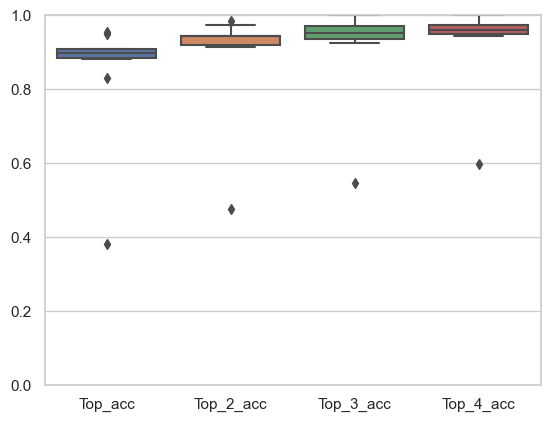

In [35]:
def plot_accuracy_paper(folder,atlas):

    all_accs = None

    for file in os.listdir(folder):

        if file[-4:]=='.csv' and file[-7]=='a':
            gt = pd.read_csv(folder+'/'+file, skiprows=7)
            gt = gt.rename(columns={'User ID':'ID'})
            autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/'+file)

            IDd, per_ID, accs = get_accuracy(gt, autID, LR=True, atlas=atlas)

            print(file)
            print(accs[0])

            if all_accs is None:
                all_accs = np.asarray(accs)

            else:
                all_accs = np.vstack((all_accs, accs))

        else:
            continue

    df = pd.DataFrame(all_accs, columns=['Top_acc', 'Top_2_acc', 'Top_3_acc', 'Top_4_acc'])

    sns.boxplot(data=df, orient='v')

    plt.ylim((0,1))

    plt.show()

    return df


df = plot_accuracy_paper('/Users/danielysprague/foco_lab/data/NP_paper/all', atlas)

In [49]:
old_FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_foco')

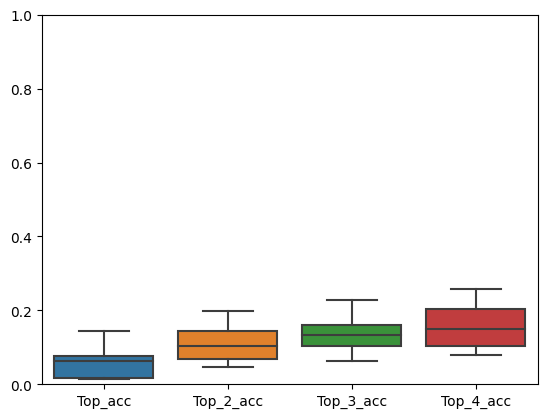

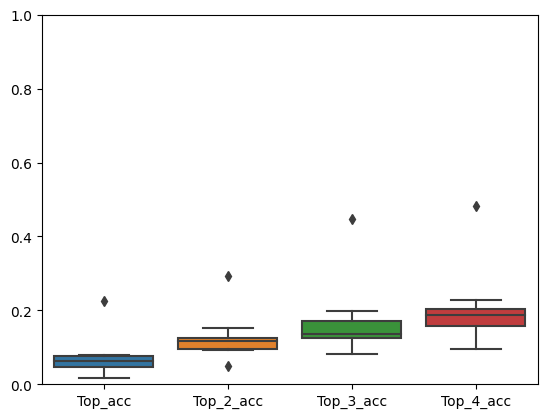

In [56]:
%matplotlib inline

def plot_accuracy(dataset, csv_folder, atlas):

    all_accs = np.zeros((len(dataset), 4))

    for i, key in enumerate(dataset.keys()):
        csv_nwb = csv_folder+key+'.csv'
        IDd, per_ID, accs = get_accuracy(dataset[key], pd.read_csv(csv_nwb), LR=True, atlas=atlas)

        all_accs[i,:4] = np.transpose(np.asarray(accs))

    df = pd.DataFrame(all_accs, columns=['Top_acc', 'Top_2_acc', 'Top_3_acc', 'Top_4_acc'])

    sns.boxplot(data=df, orient='v')

    plt.ylim((0,1))

    plt.show()

    return df



df = plot_accuracy(chaud_dataset, '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match/', atlas)
df = plot_accuracy(chaud_dataset, '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results/', atlas)

    
        

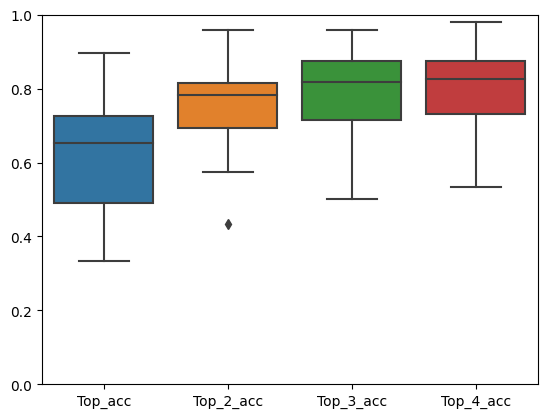

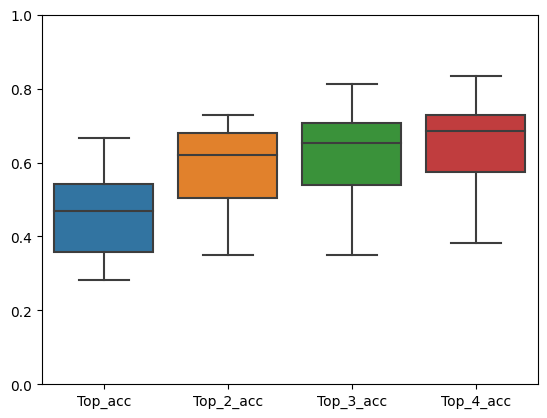

In [57]:
df = plot_accuracy(old_FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_foco_results_match/', atlas)
df = plot_accuracy(old_FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_foco_results/', atlas)

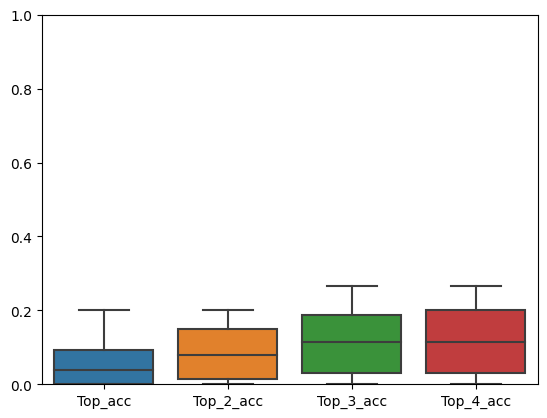

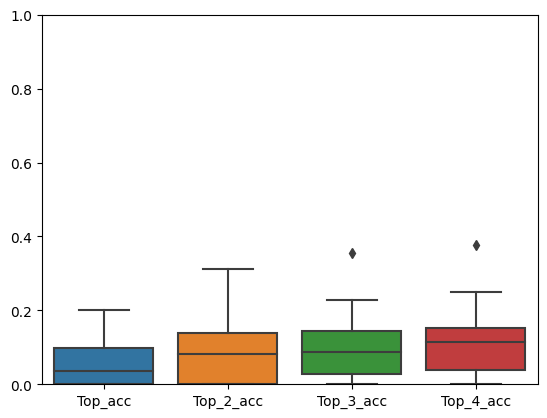

In [58]:
df = plot_accuracy(FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', atlas)
df = plot_accuracy(FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_Ray_results/', atlas)

In [69]:
%matplotlib qt
acc_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results/', '/Users/danielysprague/foco_lab/data/NWB_foco_results/', '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'chaudhary'], LR=True, atlas=atlas)
acc_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results_match/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', '/Users/danielysprague/foco_lab/data/NWB_foco_results_match/', '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'chaudhary'], LR=True, atlas=atlas)
acc_matched_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results_match_new/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match_new/', '/Users/danielysprague/foco_lab/data/NWB_foco_results_match_new/', '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match_new/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'chaudhary'], LR=True, atlas=atlas)
    

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [60]:
acc_df

top_acc top_2_acc top_3_acc top_4_acc   dataset          identifier
0   0.910995  0.947644  0.958115  0.968586        NP            56_YAaDV
1   0.905263  0.978947  0.984211  0.984211        NP            38_YAaDV
2   0.920213  0.962766  0.973404  0.978723        NP            76_YAaDV
3   0.896373  0.958549  0.974093  0.989637        NP            11_YAaLR
4   0.878307  0.957672  0.962963  0.973545        NP            64_YAaDV
..       ...       ...       ...       ...       ...                 ...
56  0.365079   0.52381  0.634921  0.666667  FOCO_old  2022-02-12-w01-NP1
57    0.6875    0.8125  0.854167  0.854167  FOCO_old  2022-01-22-w04-NP1
58       0.6       0.7     0.725     0.725  FOCO_old  2022-04-26-w01-NP1
59       0.5  0.657895  0.736842  0.789474  FOCO_old  2022-04-26-w00-NP1
60  0.204545  0.409091  0.522727  0.568182  FOCO_old  2022-04-01-w00-NP1

[61 rows x 6 columns]

In [380]:
acc_df.to_csv('/Users/danielysprague/foco_lab/data/acc_results.csv')

In [83]:
def get_accuracies_newatlas(folder, atlas):
    accs = {}
    for file in os.listdir(folder):
        filename = file[:-4]
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        per_ID, per_corr, df_assigns = run_linear_assignment(df_data, atlas)

        accs[filename] = per_corr
    
    return accs

accs_NP = get_accuracies_newatlas('/Users/danielysprague/foco_lab/data/aligned_NP', NP_atlas)
accs_full = get_accuracies_newatlas('/Users/danielysprague/foco_lab/data/aligned_full', NWB_atlas)

In [91]:
def plot_accuracies_newatlas(datasets, accs_NP, accs_full, labels):

    df = pd.DataFrame(columns=['acc_NP','acc_full', 'dataset'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            acc_NP = accs_NP[key]
            acc_full = accs_full[key]

            df.loc[len(df.index)] = [acc_NP, acc_full, labels[i]]

    fig, axs = plt.subplots(1,2)

    sns.boxplot(ax= axs[0], data = df, x = 'dataset', y='acc_NP', hue='dataset', orient='v',dodge=False) 
    sns.boxplot(ax= axs[1], data = df, x = 'dataset', y='acc_full', hue='dataset', orient='v',dodge=False) 
    sns.scatterplot(ax= axs[0], data = df, x = 'dataset', y='acc_NP', hue='dataset') 
    sns.scatterplot(ax= axs[1], data = df, x = 'dataset', y='acc_full', hue='dataset') 
    axs[0].set_ylim((0,1))
    axs[1].set_ylim((0,1))
    
    for ax in axs:
        ax.legend([],[], frameon=False)
    
plot_accuracies_newatlas([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset], accs_NP, accs_full, ['NP', 'Chaudhary', 'Yemini', 'Old FOCO', 'New FOCO'])

-8.681597328887555
1.1349352314164558e-12


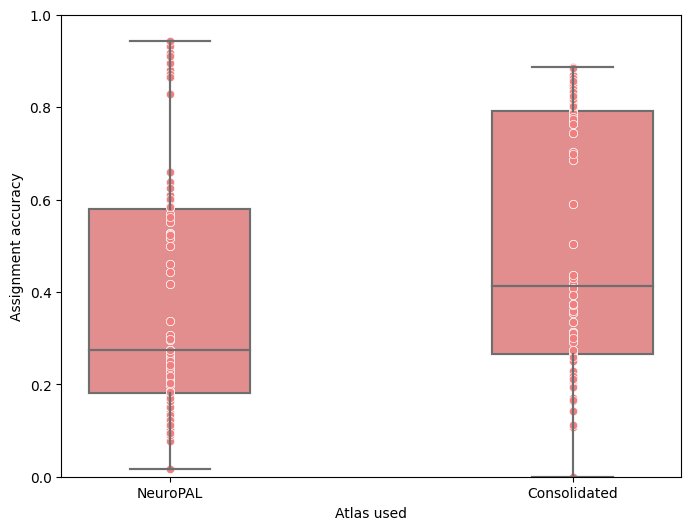

In [108]:
%matplotlib inline
import scipy.stats as stats

def plot_accuracies_atlas_compare(datasets, accs_NP, accs_full):

    df = pd.DataFrame(columns=['NeuroPAL','Consolidated', 'dataset'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            acc_NP = accs_NP[key]
            acc_full = accs_full[key]

            df.loc[len(df.index)] = [acc_NP, acc_full, key]
    
    df_long = pd.melt(df, id_vars='dataset', value_vars=['NeuroPAL', 'Consolidated'], var_name='Accuracy', value_name='Value')

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Accuracy', y='Value', data=df_long, color='skyblue', width=0.4)
    sns.boxplot(x='Accuracy', y='Value', data=df_long, color='lightcoral', width=0.4)
    sns.scatterplot(x='Accuracy', y='Value', data=df_long, color='skyblue')
    sns.scatterplot(x='Accuracy', y='Value', data=df_long, color='lightcoral')

    t, prob = stats.ttest_rel(np.asarray(df['NeuroPAL']), np.asarray(df['Consolidated']))

    plt.ylabel('Assignment accuracy')
    plt.xlabel('Atlas used')
    plt.ylim((0,1))

    print(t)
    print(prob)
    # Add lines connecting data points from the same dataset
    #for i in range(len(df)):
    #    plt.plot([i, i], [df['acc_NP'][i], df['acc_full'][i]], color='gray', linestyle='-', linewidth=1, alpha=0.7)

    plt.show()

plot_accuracies_atlas_compare([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset], accs_NP, accs_full)

In [109]:
print(accs_NP)
print(accs_full)

{'6': 0.336283185840708, '7': 0.27350427350427353, '20221106-21-00-09': 0.10344827586206896, '20230322-20-16-50': 0.11382113821138211, '5': 0.25203252032520324, '4': 0.29508196721311475, '2021-12-03-w00-NP1': 0.2558139534883721, '20221106-21-47-31': 0.16379310344827586, '20230322-22-43-03': 0.13445378151260504, '20230506-12-56-00': 0.2376237623762376, '20230506-14-24-57': 0.2980769230769231, '1': 0.18584070796460178, '38_YAaDV': 0.9333333333333333, '20230510-13-25-46': 0.15178571428571427, '20230412-20-15-17': 0.10752688172043011, '56_YAaDV': 0.8717948717948718, '20190928_08': 0.5683060109289617, '3': 0.1794871794871795, '2': 0.19834710743801653, '20191104_10': 0.5172413793103449, '20190929_06': 0.5168539325842697, '64_YAaDV': 0.8958333333333334, '20190929_07': 0.5988700564971752, '20230510-16-36-46': 0.12195121951219512, '20191030_03': 0.6378378378378379, '20190929_05': 0.4176470588235294, '2022-03-05-w00-NP1': 0.17857142857142858, '20190925_04': 0.6101694915254238, '11_YAaLR': 0.8711

In [80]:
datasets = [NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset]
names = ['NP', 'Chaudhary', 'Yemini', 'Old FOCO', 'New FOCO']
for i, dataset in enumerate(datasets):
    print(names[i])
    print(len(dataset.keys()))


NP
10
Chaudhary
9
Yemini
21
Old FOCO
10
New FOCO
20


In [82]:
print(accs_NP)
print(accs_full)

[0.336283185840708, 0.27350427350427353, 0.10344827586206896, 0.11382113821138211, 0.25203252032520324, 0.29508196721311475, 0.2558139534883721, 0.16379310344827586, 0.13445378151260504, 0.2376237623762376, 0.2980769230769231, 0.18584070796460178, 0.9333333333333333, 0.15178571428571427, 0.10752688172043011, 0.8717948717948718, 0.5683060109289617, 0.1794871794871795, 0.19834710743801653, 0.5172413793103449, 0.5168539325842697, 0.8958333333333334, 0.5988700564971752, 0.12195121951219512, 0.6378378378378379, 0.4176470588235294, 0.17857142857142858, 0.6101694915254238, 0.8711340206185567, 0.8808290155440415, 0.46111111111111114, 0.5271739130434783, 0.07692307692307693, 0.4438202247191011, 0.3072289156626506, 0.16981132075471697, 0.25139664804469275, 0.2748091603053435, 0.21428571428571427, 0.11214953271028037, 0.20689655172413793, 0.659217877094972, 0.26857142857142857, 0.24271844660194175, 0.18333333333333332, 0.8290155440414507, 0.1746987951807229, 0.5232558139534884, 0.6243093922651933

In [77]:
def plot_accuracies(datasets, csv_folders, labels, LR=False, atlas=None, title = 'Accuracy by dataset'):

    num_data_total = np.sum([len(dataset.keys()) for dataset in datasets])

    accs = np.empty((num_data_total, 6), dtype='O')

    k=0

    for i, dataset in enumerate(datasets):
        csv_folder = csv_folders[i]
        label = labels[i]
        for j, key in enumerate(dataset.keys()):
            csv = csv_folder + key +'.csv'
            IDd, per_ID, acc = get_accuracy(dataset[key], pd.read_csv(csv), LR=LR, atlas=atlas)
            acc.append(label)
            acc.append(key)
            accs[k,:] = acc
            k+=1

    df = pd.DataFrame(accs, columns = ['top_acc', 'top_2_acc', 'top_3_acc', 'top_4_acc', 'dataset', 'identifier'])

    sns.boxplot(data=df, x = 'dataset', y='top_acc', hue='dataset', orient='v', dodge=False)

    plt.ylabel('Percent autoID accuracy')
    plt.ylim((0,1))

    plt.title('NeuroPAL AutoID accuracy by dataset')

    plt.show()

    return df

acc_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results_match/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', '/Users/danielysprague/foco_lab/data/NWB_foco_results_match/','/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'Chaudhary'], LR=True, atlas=atlas)

    

In [77]:
color_df

avg_col_discrim             identifier
0          0.233278  20230412-20-15-17.nwb
1          0.182110  20230506-14-24-57.nwb
2          0.275786  20230510-13-25-46.nwb
3          0.145156  20230322-22-43-03.nwb
4          0.163429  20221106-21-47-31.nwb
..              ...                    ...
56         1.837451           70_YAaLR.nwb
57         2.101219           55_YAaDV.nwb
58         1.792815            7_YAaLR.nwb
59         1.785512           62_YAaLR.nwb
60         2.016502           20_YAaLR.nwb

[61 rows x 2 columns]

In [79]:
color_acc = acc_df.merge(color_df, on='identifier')

In [80]:
color_acc

top_acc top_2_acc top_3_acc top_4_acc   dataset          identifier  \
0   0.910995  0.947644  0.958115  0.968586        NP            56_YAaDV   
1   0.905263  0.978947  0.984211  0.984211        NP            38_YAaDV   
2   0.920213  0.962766  0.973404  0.978723        NP            76_YAaDV   
3   0.896373  0.958549  0.974093  0.989637        NP            11_YAaLR   
4   0.878307  0.957672  0.962963  0.973545        NP            64_YAaDV   
..       ...       ...       ...       ...       ...                 ...   
56  0.365079   0.52381  0.634921  0.666667  FOCO_old  2022-02-12-w01-NP1   
57    0.6875    0.8125  0.854167  0.854167  FOCO_old  2022-01-22-w04-NP1   
58       0.6       0.7     0.725     0.725  FOCO_old  2022-04-26-w01-NP1   
59       0.5  0.657895  0.736842  0.789474  FOCO_old  2022-04-26-w00-NP1   
60  0.204545  0.409091  0.522727  0.568182  FOCO_old  2022-04-01-w00-NP1   

    avg_col_discrim  
0          1.807562  
1          1.991833  
2          1.799838  
3          1.905245  
4          2.160154  
..              ...  
56         0.468498  
57         0.307903  
58         0.267753  
59         0.569796  
60         0.464199  

[61 rows x 7 columns]

## Figure 5: Atlas visualizations - projected color space visualization, unrollled butterfly visualization